In [1249]:
import pandas as pd
from statsmodels import stats 
import matplotlib.pyplot as plt
import copy
import numpy as np
import math

#stats.weightstats.ttest_ind



In [420]:
def binplot_dim(ax, x, y, nbins, **kwargs):
    df_xy = pd.DataFrame({'x':x,'y':y})
    df_xy = df_xy.sort_values('x')
    df_xy['xbin'] = pd.cut(df_xy['x'], nbins,)

    df_mean = df_xy.groupby('xbin').mean().reset_index()
    df_mean = df_mean[['xbin','y']]
    df_mean.columns = ['xbin','ybar']  

    df_xy = df_xy.merge(df_mean, how='left', on='xbin')
    df_xy['ysqerr'] = (df_xy['y']-df_xy['ybar'])**2
    df_xy['count'] = 1
    df_xy = df_xy.groupby('xbin').sum()
    df_xy = df_xy.reset_index()

    xbin = [[i.left, i.right] for i in df_xy['xbin'].tolist()]
    df_xy['xbin'] = xbin
    df_xy['x'] = [sum(i)/2 for i in xbin]
    df_xy['ystdev'] = (df_xy['ysqerr']/df_xy['count'])**0.5
    df_xy['ybar'] = df_xy['y']/df_xy['count']
    df_xy['ci_95'] = 1.96*(df_xy['ystdev'] / df_xy['count']**0.5)


    #display(df_xy)
    #for k,v in kwargs.items():
    #    print(k,v)

    for i in xbin:
        ax.axvline(i[0], linestyle='--', c='grey', alpha=0.5)
    ax.axvline(xbin[-1][1], linestyle='--', c='grey', alpha=0.5)

    if 'linestyle' in kwargs.keys():
        style = kwargs['linestyle']
    else:
        style = '-'

    ax.plot(df_xy['x'], df_xy['ybar'],c=kwargs['c'], linestyle=style, linewidth = int(kwargs['l']), label=kwargs['label'])
    ax.scatter(df_xy['x'], df_xy['ybar'],c=kwargs['c'], s = kwargs['s'])
    
    x_mid = df_xy['x'].tolist()
    ybar = df_xy['ybar'].tolist()
    ci95 = df_xy['ci_95'].tolist()
    
    for i in range(len(x_mid)):
        xt = x_mid[i]
        ymin = ybar[i]-ci95[i]
        ymax = ybar[i]+ci95[i]
        ax.vlines(x_mid[i], ymin=ymin, ymax=ymax, colors=kwargs['c'], linewidth = int(kwargs['l']))
        ax.scatter([xt,xt],[ymin,ymax], marker='_', c=kwargs['c'], s=kwargs['s'])
    return ax

In [421]:
f = './data/social_trends_dataset.csv'
df = pd.read_csv(f)
df['weighted_f'] = df['Family Available'] * df['weight']

In [693]:
df_resp_weight = pd.read_csv('./data/atus_resp_who_agg.csv')
df_resp_weight = df_resp_weight[['TUCASEID','NEW_WEIGHT']]
df_resp_weight.head(3)

TUCASEID  NEW_WEIGHT
0  20160101160045     20976.0
1  20160101160069     18319.0
2  20160101160094     57019.0

In [695]:
df_cbsa = pd.read_csv('./data/atus_resp_who_agg.csv')
df_cbsa = df_cbsa[['GTCBSA','POP', 'LOG_POP', 'NEW_WEIGHT']]
#df_cbsa = df_cbsa.drop_duplicates()
df_weights = df_cbsa[['GTCBSA','NEW_WEIGHT']].groupby('GTCBSA').sum()
df_cbsa = df_cbsa[['GTCBSA','POP','LOG_POP']].drop_duplicates()
df_cbsa = df_cbsa.merge(df_weights, how='left', on='GTCBSA')
display(df_weights.head(3))
df_cbsa.head(3)

NEW_WEIGHT
GTCBSA            
10180     393339.0
10420    2256628.0
10580    2830130.0

GTCBSA        POP  LOG_POP  NEW_WEIGHT
0   12060  5862424.0     6.77  18650462.0
1   47900  6196585.0     6.79  20028937.0
2   33100  6090660.0     6.78  19978327.0

In [697]:
df_resp_activity = pd.read_csv('./data/atus_resp_activity.csv')
print(df_resp_activity.shape)
display(df_resp_activity.head(3))

df_fg = pd.read_csv('./data/f(g)_all_a_wd_we.csv')
phi = df['Family Available'].sum() / len(df)
print('phi =',phi)

(31663, 25)


TUCASEID  1_agg_H  10_agg_H  11_agg_H  12_agg_H  13_agg_H  14_agg_H  \
0  20160101160045      0.0       0.0       0.0       1.0       0.0       0.0   
1  20160101160069      0.0       0.0       0.0       0.0       0.0       0.0   
2  20160101160094      0.0       0.0       0.0       0.0       0.0       0.0   

   15_agg_H  16_agg_H  18_agg_H  ...  7_agg_H  8_agg_H  9_agg_H  ALL_TU_H  \
0       0.0       0.0       0.0  ...      0.0      0.0      0.0       1.0   
1       0.0       0.0       0.0  ...      0.0      0.0      0.0       0.0   
2       0.0       0.0       0.0  ...      0.0      0.0      0.0       0.0   

   SOCIAL_TU_H  CARE_TU_H  LONGEST_TRIP_DUR  LONGEST_TRIP_TIER2CODE  Division  \
0          1.0        0.0              15.0                    12.0         5   
1          0.0        0.0              30.0                     7.0         5   
2          0.0        0.0              10.0                    13.0         5   

   TUDIARYDAY  
0           6  
1           1  
2           1  

[3 rows x 25 columns]

phi = 0.8150442477876106


In [426]:
# def categorical_t_test(df, test_col):
#     tdf = df[['weight', 'weighted_f',test_col]]
#     classes = []
#     means = []
#     for i in tdf[test_col].unique().tolist():
#         t_tdf = tdf[tdf[test_col]==i]
#         mean = t_tdf['weighted_f'].sum() / t_tdf['weight'].sum()
#         if mean > 0:
#             classes.append(i)
#             means.append(mean)
#     plt.bar(classes, [int(i*100) for i in means])
#     plt.xticks(rotation = 45, ha='right') 
#     plt.ylabel('f(usa) (x100)')
#     plt.show()

# for i in ['sex', 'Education','income_short','recage','racethn']:
#     categorical_t_test(df, i)


In [692]:
atus_df = pd.read_csv('./data/atus_responses_2016-2019.csv')
atus_df = atus_df[['TUCASEID', 'TEAGE', 'TESEX', 'HEFAMINC', 'PTDTRACE', 'PEHSPNON', 'PEEDUCA', 'GTCBSA']]
atus_df.columns = ['TUCASEID', 'Age', 'Sex', 'Fam_Inc', 'Race', 'Hisp', 'Educ', 'GTCBSA']
atus_df = atus_df[atus_df['GTCBSA']>0]

print(atus_df.shape)
atus_df.head()

(31795, 8)


TUCASEID  Age  Sex  Fam_Inc  Race  Hisp  Educ  GTCBSA
0  20160101160045   62    2        3     1     2    39   12060
2  20160101160069   24    2        4     2     2    39   47900
5  20160101160094   16    2        5     3     1    36   33100
6  20160101160116   43    2       16     1     2    43   35620
8  20160101160139   63    1       16     1     2    46   17140

In [429]:
race = {#1: 'White', 
        2: 'Black', 
        #3: 'AmericanIndian', 
        #4: 'Asian', 
        #5: 'PacificIslander/Hawaiian'
        }

ethn = {1: 'Hispanic', 
        2: 'NonHispanic'}

sex  = {1: 'Male',
        2: 'Female'}

educ = {39: 'HighSchoolGraduate'}

### Sex Encoding

In [430]:
atus_encoded_df = copy.deepcopy(atus_df)
atus_encoded_df['SexClass'] = atus_encoded_df['Sex'].apply(lambda x: sex[x])
atus_encoded_df.head()

TUCASEID  Age  Sex  Fam_Inc  Race  Hisp  Educ  GTCBSA SexClass
0  20160101160045   62    2        3     1     2    39   12060   Female
2  20160101160069   24    2        4     2     2    39   47900   Female
5  20160101160094   16    2        5     3     1    36   33100   Female
6  20160101160116   43    2       16     1     2    43   35620   Female
8  20160101160139   63    1       16     1     2    46   17140     Male

### Race Encoding

In [431]:
atus_encoded_df['Race_Encoded'] = [race[i] if i in race.keys() else 'White&Other' for i in atus_encoded_df['Race'].tolist()]
atus_encoded_df['Ethn_Encoded'] = [ethn[i] if i in ethn.keys() else 'White&Other' for i in atus_encoded_df['Hisp'].tolist()]
r = atus_encoded_df['Race_Encoded'].tolist()
e = atus_encoded_df['Ethn_Encoded'].tolist()
re = [r[i] if e[i] == 'NonHispanic' else 'Hispanic' for i in range(len(r))]
atus_encoded_df['RaceEthn' ] = re

### Age Encoding

In [432]:
def age_class(x):
    if x < 23:
        return 'Age<23'
    elif x < 60:
        return '23<=Age<60'
    elif x >= 60:
        return 'Age>=60'
    else: return x

atus_encoded_df['AgeClass'] = atus_encoded_df['Age'].apply(age_class)

### Education Encoding

In [433]:
def education_class(x):
    if x > 38:
        return 'HS+'
    else:
        return 'LT_HS'

atus_encoded_df['EduClass'] = atus_encoded_df['Educ'].apply(education_class)

### Grouping

In [434]:
atus_encoded_df = copy.copy(atus_encoded_df[['TUCASEID', 'GTCBSA','SexClass', 'RaceEthn', 'AgeClass', 'EduClass']])
atus_raw_counts = atus_encoded_df[['TUCASEID','GTCBSA']].groupby('GTCBSA').count()
for col in ['SexClass', 'RaceEthn', 'AgeClass', 'EduClass']:
    for val in atus_encoded_df[col].unique():
        tdf = atus_encoded_df[atus_encoded_df[col]==val]
        tdf = tdf[[col,'GTCBSA']].groupby('GTCBSA').count()
        tdf.columns = [col+'_'+val]
        atus_raw_counts = atus_raw_counts.join(tdf)  

atus_raw_counts.head()

TUCASEID  SexClass_Female  SexClass_Male  RaceEthn_White&Other  \
GTCBSA                                                                   
10180         35               22             13                  27.0   
10420         88               54             34                  72.0   
10580         91               57             34                  77.0   
10740        164               84             80                  85.0   
10900         86               52             34                  78.0   

        RaceEthn_Black  RaceEthn_Hispanic  AgeClass_Age>=60  \
GTCBSA                                                        
10180              3.0                5.0                 7   
10420             13.0                3.0                32   
10580             10.0                4.0                34   
10740              7.0               72.0                61   
10900              2.0                6.0                34   

        AgeClass_23<=Age<60  AgeClass_Age<23  EduClass_HS+  EduClass_LT_HS  
GTCBSA                                                                      
10180                    28              NaN            33             2.0  
10420                    52              4.0            84             4.0  
10580                    49              8.0            83             8.0  
10740                    91             12.0           156             8.0  
10900                    45              7.0            82             4.0

In [435]:
vars = {}
cols = ['SexClass', 'RaceEthn', 'AgeClass', 'EduClass']

for col in cols:
    vars[col] = atus_encoded_df[col].unique().tolist()


atus_pairwise_counts = atus_encoded_df[['TUCASEID','GTCBSA']].groupby('GTCBSA').count()

for col in cols[1:]:
    for val in vars[col]:
        for gender in vars['SexClass']:
            tdf = atus_encoded_df[atus_encoded_df[col]==val]
            tdf = tdf[tdf['SexClass']==gender]
            tdf = tdf[[col,'GTCBSA']].groupby('GTCBSA').count()
            tdf.columns = [col+'_'+val+'_'+gender]
            atus_pairwise_counts = atus_pairwise_counts.merge(tdf, how='left', on='GTCBSA')  

atus_pairwise_counts = atus_pairwise_counts.reset_index()
atus_pairwise_counts = df_cbsa.merge(atus_pairwise_counts, how='inner',on='GTCBSA')

atus_pairwise_counts = atus_pairwise_counts.replace(np.nan, 0)

### c vs. log(pop(g))

### To-do
<!-- 
1. Bring in $c$ and $p(g)$ and examine $p(g,c)$ ($p(g,c)$ is not fundamental)
2. Do equation 52
3. Get distributions of Kappa
4. Add f_weekend and f_weekday to plasma charts
5. Work with the team for how to present this
6. Polish up heatmaps of f(g) & nail down the presentation of those plots
7. Collectively decide on regressions

* Do REAL phi's for these (use PEW data for the cities we DO have)
* MATCH f(g) threshold to PEW research threshold -->

1. Bring in $c$ and $p(g)$ from the original Pew dataset and examine $p(g,c)$ ($p(g,c)$ is  
    not fundamental). This is based on the p(g,c) from Unchitta
2. Do equation 52
3. Get distributions of Kappa
Items 2 and 3 are related/supported by the quality of the results in items 9 and 10 below.
4. Add f_weekend and f_weekday to plasma charts
5. Work with the team for how to present this
6. Polish up plasma charts of f(g) & nail down the presentation of those plots
7. Collectively decide on regressions (do this last)
8. Measure <phi(c)> (eq. 46)
9. Test Eq. 50 for the cities we have in Pew
10. Test Eq. 47 for the cities we have in Pew
11. Do eq. 45

* Do REAL phi's for these (use PEW data for the cities we DO have)-- In particular, measure  
    phi as a function of p just like we do f as a function of p. Note that point 10 is very  
    related because if the simplification phi(g,c) is approximately equal to <phi(c)>, the  
    tests in points 9 and 10 will work and eq 47 will be good approximation of phi(g).
* MATCH f(g) threshold to PEW research threshold 

### $\kappa_\alpha$ - Eq. 45

In [438]:
# # Quick check on weight sums()

# weights = df_weights.reset_index()
# weights = weights.merge(cbsa_weights, how='inner', on='GTCBSA')
# weights['diff'] = weights['NEW_WEIGHT_x'] - weights['NEW_WEIGHT_y']
# weights['diff'].max()

# # Result: all good, 0 difference

In [439]:
cbsa_weights = df_cbsa[['GTCBSA', 'NEW_WEIGHT']]
kappa_df = cbsa_weights.merge(df_fg, on='GTCBSA', how='left')
kappa_df.head()

GTCBSA  NEW_WEIGHT  f(g)_all_1_agg_H  f(g)_we_1_agg_H  f(g)_wd_1_agg_H  \
0   12060  18650462.0          0.003090         0.006395         0.000000   
1   47900  20028937.0          0.000000         0.000000         0.000000   
2   33100  19978327.0          0.002565         0.002115         0.003001   
3   35620  63855127.0          0.001674         0.002835         0.000524   
4   17140   6751214.0          0.000000         0.000000         0.000000   

   f(g)_all_10_agg_H  f(g)_we_10_agg_H  f(g)_wd_10_agg_H  f(g)_all_11_agg_H  \
0                0.0               0.0               0.0           0.099033   
1                0.0               0.0               0.0           0.084142   
2                0.0               0.0               0.0           0.080272   
3                0.0               0.0               0.0           0.096656   
4                0.0               0.0               0.0           0.105136   

   f(g)_we_11_agg_H  ...  f(g)_wd_9_agg_H  f(g)_all_ALL_TU_H  \
0          0.149360  ...         0.001464           0.183719   
1          0.123374  ...         0.000000           0.137278   
2          0.090671  ...         0.000000           0.149766   
3          0.135548  ...         0.000000           0.167588   
4          0.155755  ...         0.000000           0.206717   

   f(g)_we_ALL_TU_H  f(g)_wd_ALL_TU_H  f(g)_all_SOCIAL_TU_H  \
0          0.258521          0.108596              0.155085   
1          0.170135          0.104441              0.114245   
2          0.152353          0.146379              0.124065   
3          0.214408          0.120750              0.148391   
4          0.265395          0.142116              0.172935   

   f(g)_we_SOCIAL_TU_H  f(g)_wd_SOCIAL_TU_H  f(g)_all_CARE_TU_H  \
0             0.226408             0.084373            0.040657   
1             0.156499             0.067841            0.028695   
2             0.127122             0.120346            0.032453   
3             0.202055             0.094924            0.032930   
4             0.230661             0.108916            0.032233   

   f(g)_we_CARE_TU_H  f(g)_wd_CARE_TU_H  
0           0.054706           0.026268  
1           0.029879           0.029104  
2           0.035987           0.028751  
3           0.041873           0.023979  
4           0.032429           0.032501  

[5 rows x 62 columns]

In [440]:
kappa_df = cbsa_weights.merge(df_fg, on='GTCBSA', how='left')
cols = kappa_df.columns.tolist()[2:]

for col in cols:
    kappa_df[col] = kappa_df[col] * kappa_df['NEW_WEIGHT']

weight_sum = kappa_df['NEW_WEIGHT'].sum()


kappa_sums = pd.DataFrame(kappa_df.sum())

kappa_sums = kappa_sums.reset_index().loc[2:]

kappa_sums.columns = ['Variable','Sum']
kappa_sums['period'] = kappa_sums['Variable'].apply(lambda x: x[5:8])
kappa_sums['period'] = kappa_sums['period'].apply(lambda x: x.replace('_',''))
kappa_sums['activity'] = kappa_sums['Variable'].apply(lambda x: x[8:])
kappa_sums['activity'] = kappa_sums['activity'].apply(lambda x: x[1:] if x[0]=='_' else x)
kappa_sums['activity'] = kappa_sums['activity'].apply(lambda x: '0'+x if len(x) < 8 else x)
kappa_sums = kappa_sums.sort_values('activity')
kappa_sums['Sum'] = (kappa_sums['Sum'] / weight_sum) / phi
kappa_sums = kappa_sums[['Sum','period','activity']]
kappa_sums = pd.pivot_table(kappa_sums, values = 'Sum', index = 'activity', columns = 'period')
kappa_sums = kappa_sums.reset_index()


codes = {
'01_agg_H': 'Personal Care', 
'02_agg_H': 'Household Activities', 
'03_agg_H': 'Care for HH Members', 
'04_agg_H': 'Care for NH Members', 
'05_agg_H': 'Work', 
'06_agg_H': 'Education', 
'07_agg_H': 'Consumer Purchases', 
'08_agg_H': 'Prof. & Pers. Services',
'09_agg_H': 'Household Services', 
'10_agg_H': 'Govt Services & Civic', 
'11_agg_H': 'Eating & Drinking', 
'12_agg_H': 'Socializing & Leisure', 
'13_agg_H': 'Sports, Exrc & Rec', 
'14_agg_H': 'Religious & Spiritual', 
'15_agg_H': 'Volunteer Activities', 
'16_agg_H': 'Phone calls', 
'18_agg_H': 'Traveling', 
'ALL_TU_H': 'All Activities', 
'CARE_TU_H': 'Care-Related Activities', 
'SOCIAL_TU_H': 'Social Activities'
}

descriptions = [codes[i] for i in kappa_sums['activity'].tolist()]
kappa_sums['Description'] = descriptions
kappa_sums = kappa_sums[['Description','activity','all','wd','we']]

kappa_sums

period              Description     activity       all        wd        we
0                 Personal Care     01_agg_H  0.001381  0.001372  0.001364
1          Household Activities     02_agg_H  0.054598  0.038781  0.069456
2           Care for HH Members     03_agg_H  0.019235  0.018605  0.020139
3           Care for NH Members     04_agg_H  0.053230  0.049109  0.057960
4                          Work     05_agg_H  0.006879  0.008822  0.005059
5                     Education     06_agg_H  0.002022  0.002571  0.001506
6            Consumer Purchases     07_agg_H  0.034097  0.024628  0.043343
7        Prof. & Pers. Services     08_agg_H  0.004804  0.005978  0.003610
8            Household Services     09_agg_H  0.001639  0.002260  0.000998
9         Govt Services & Civic     10_agg_H  0.000515  0.000873  0.000182
10            Eating & Drinking     11_agg_H  0.120243  0.081298  0.158124
11        Socializing & Leisure     12_agg_H  0.158310  0.111204  0.204428
12           Sports, Exrc & Rec     13_agg_H  0.016070  0.010105  0.021542
13        Religious & Spiritual     14_agg_H  0.011334  0.003066  0.019300
14         Volunteer Activities     15_agg_H  0.003756  0.003102  0.004380
15                  Phone calls     16_agg_H  0.003654  0.003082  0.004158
16                    Traveling     18_agg_H  0.091277  0.076166  0.106339
17               All Activities     ALL_TU_H  0.232512  0.185016  0.279422
18      Care-Related Activities    CARE_TU_H  0.053230  0.049109  0.057960
19            Social Activities  SOCIAL_TU_H  0.197398  0.143315  0.250239

$$\tilde\kappa(g,\mathbf{c},\alpha) = \frac{u(g,\mathbf{c},\alpha)}{\langle\phi(\mathbf{c})\rangle}$$
where $u(g,\mathbf{c},\alpha)$ is the unweighted proportion of survey respondents living in $g$  
with personal features $\mathbf{c}$ that report doing activity $\alpha$ when surveyed,  
and where
$$\langle\phi(\mathbf{c})\rangle=\frac{\sum_{g}\phi(g,\mathbf{c})p(g,\mathbf{c})}{\sum_{g}p(g,\mathbf{c})}$$

### Cleaning Pew Research Data

In [450]:
# # From prior functions:
# def age_class(x):
#     if x < 23:
#         return 'Age<23'
#     elif x < 60:
#         return '23<=Age<60'
#     else:
#         return 'Age>=60'

# atus_encoded_df['Race_Encoded'] = [race[i] if i in race.keys() else 'White&Other' for i in atus_encoded_df['Race'].tolist()]
# atus_encoded_df['Ethn_Encoded'] = [ethn[i] if i in ethn.keys() else 'White&Other' for i in atus_encoded_df['Hisp'].tolist()]
# r = atus_encoded_df['Race_Encoded'].tolist()
# e = atus_encoded_df['Ethn_Encoded'].tolist()
# re = [r[i] if e[i] == 'NonHispanic' else 'Hispanic' for i in range(len(r))]
# atus_encoded_df['RaceEthn' ] = re

def race_classifier(x):
    if x == 'Black~H':
        return 'Black'
    elif x == 'Other':
        return 'White&Other'
    elif x == 'White~H':
        return 'White&Other'
    else: return x

def edu_classifer(x):
    if x == 'lt_highschool':
        return 'LT_HS'
    elif x in ['some_college', 'highschool', 'post_college_degree', 'trade_school_hs', 'college_degree']:
        return 'HS+'
    else:
        return x

In [445]:
df_pew

msa          state   FIPS   GTCBSA     sex q7_family_members  \
0     14860    Connecticut   9001  14860.0  Female              None   
1     13820        Alabama   1115  13820.0  Female         1 up to 5   
2     13820        Alabama   1021  13820.0  Female      More than 20   
3     13820        Alabama   1073  13820.0  Female        6 up to 10   
4     42660     Washington  53033  42660.0  Female              None   
...     ...            ...    ...      ...     ...               ...   
2255  35620     New Jersey  34027  35620.0  Female         1 up to 5   
2256  35620     New Jersey  34027  35620.0    Male       11 up to 20   
2257  35620     New Jersey  34013  35620.0    Male              None   
2258  14460  Massachusetts  25009  14460.0    Male         1 up to 5   
2259  29620       Michigan  26037  29620.0    Male       11 up to 20   

      NO family  Family Available age            Education income_short  \
0             1                 0  44         some_college       10-20k   
1             0                 1  49           highschool       10-20k   
2             0                 1  74        lt_highschool       10-20k   
3             0                 1  80           highschool       10-20k   
4             1                 0  26  post_college_degree       10-20k   
...         ...               ...  ..                  ...          ...   
2255          0                 1  70  post_college_degree          NaN   
2256          0                 1  28  post_college_degree          NaN   
2257          1                 0  60           highschool          NaN   
2258          0                 1  76           highschool          NaN   
2259          0                 1  59           highschool          NaN   

     recage  racethn    weight  weighted_f    AgeClass SexClass    EthnClass  
0     35-44  White~H  3.547619    0.000000  23<=Age<60   Female  White&Other  
1     45-54  Black~H  2.250000    2.250000  23<=Age<60   Female        Black  
2       65+  White~H  2.523810    2.523810     Age>=60   Female  White&Other  
3       65+  White~H  3.333333    3.333333     Age>=60   Female  White&Other  
4     25-34  White~H  5.119048    0.000000  23<=Age<60   Female  White&Other  
...     ...      ...       ...         ...         ...      ...          ...  
2255    65+  White~H  1.018868    1.018868     Age>=60   Female  White&Other  
2256  25-34  White~H  1.687500    1.687500  23<=Age<60     Male  White&Other  
2257  55-64  White~H  3.187500    0.000000     Age>=60     Male  White&Other  
2258    65+  White~H  2.245283    2.245283     Age>=60     Male  White&Other  
2259  55-64  White~H  1.754717    1.754717  23<=Age<60     Male  White&Other  

[2260 rows x 18 columns]

In [481]:
df_pew = copy.deepcopy(df)
df_pew = df_pew[df_pew.columns.tolist()[1:]]

df_pew['AgeClass'] = df_pew['age'].replace('97 or older', 97).astype(float).apply(age_class)
df_pew['SexClass'] = df_pew['sex']
df_pew['RaceEthn'] = df_pew['racethn'].apply(race_classifier)
df_pew['EduClass'] = df_pew['Education'].apply(edu_classifer)

df_pew.head()

msa        state   FIPS   GTCBSA     sex q7_family_members  NO family  \
0  14860  Connecticut   9001  14860.0  Female              None          1   
1  13820      Alabama   1115  13820.0  Female         1 up to 5          0   
2  13820      Alabama   1021  13820.0  Female      More than 20          0   
3  13820      Alabama   1073  13820.0  Female        6 up to 10          0   
4  42660   Washington  53033  42660.0  Female              None          1   

   Family Available age            Education income_short recage  racethn  \
0                 0  44         some_college       10-20k  35-44  White~H   
1                 1  49           highschool       10-20k  45-54  Black~H   
2                 1  74        lt_highschool       10-20k    65+  White~H   
3                 1  80           highschool       10-20k    65+  White~H   
4                 0  26  post_college_degree       10-20k  25-34  White~H   

     weight  weighted_f    AgeClass SexClass     RaceEthn EduClass  
0  3.547619    0.000000  23<=Age<60   Female  White&Other      HS+  
1  2.250000    2.250000  23<=Age<60   Female        Black      HS+  
2  2.523810    2.523810     Age>=60   Female  White&Other    LT_HS  
3  3.333333    3.333333     Age>=60   Female  White&Other      HS+  
4  5.119048    0.000000  23<=Age<60   Female  White&Other      HS+

In [572]:
ages = df_pew[~df_pew['age'].isna()]['age'].tolist()
ages = [97 if i == '97 or older' else int(i) for i in ages]
min(ages)

18

In [482]:
df_pew['Education'].unique()

array(['some_college', 'highschool', 'lt_highschool',
       'post_college_degree', 'trade_school_hs', nan, 'college_degree'],
      dtype=object)

In [483]:
classes = {}

for col in df_pew.columns.tolist()[-4:]:
    classes[col] = df_pew[col].unique().tolist()

np.isnan(classes['EduClass'][2])

c1_type_array = []
c1_array = []
c2_type_array = []
c2_array = []
phi_array = []

class1 = 'SexClass'
for class2 in classes.keys():
    if class2 != class1:
        for c1 in classes[class1]:
            for c2 in classes[class2]:
                if type(c2)==type(0.0):
                    pass
                else:
                    #print(class1, class2, c1, c2, type(c2))
                    tdf = df_pew[df_pew[class1]==c1]
                    tdf = tdf[tdf[class2]==c2]
                    _phi = tdf['Family Available'].sum() / len(tdf)
                    c1_array.append(c1)
                    c2_array.append(c2)
                    c1_type_array.append(class1)
                    c2_type_array.append(class2)
                    phi_array.append(_phi)

phi_c_df = pd.DataFrame({'class1_type':c1_type_array, 'class1': c1_array, 'class2_type':c2_type_array, 'class2': c2_array, 'phi_c':phi_array})
phi_c_df


class1_type  class1 class2_type       class2     phi_c
0     SexClass  Female    AgeClass   23<=Age<60  0.794379
1     SexClass  Female    AgeClass      Age>=60  0.811475
2     SexClass  Female    AgeClass       Age<23  0.833333
3     SexClass    Male    AgeClass   23<=Age<60  0.826215
4     SexClass    Male    AgeClass      Age>=60  0.834532
5     SexClass    Male    AgeClass       Age<23  0.838710
6     SexClass  Female    RaceEthn  White&Other  0.804878
7     SexClass  Female    RaceEthn        Black  0.827586
8     SexClass  Female    RaceEthn     Hispanic  0.743590
9     SexClass    Male    RaceEthn  White&Other  0.825322
10    SexClass    Male    RaceEthn        Black  0.863158
11    SexClass    Male    RaceEthn     Hispanic  0.820513
12    SexClass  Female    EduClass          HS+  0.802434
13    SexClass  Female    EduClass        LT_HS  0.801980
14    SexClass    Male    EduClass          HS+  0.826788
15    SexClass    Male    EduClass        LT_HS  0.852273

In [491]:
display(atus_encoded_df.head())
df_u_gca = atus_encoded_df.merge(df_resp_activity, how='left', on='TUCASEID')
display(df_u_gca.head())

TUCASEID  GTCBSA SexClass     RaceEthn    AgeClass EduClass
0  20160101160045   12060   Female  White&Other     Age>=60      HS+
2  20160101160069   47900   Female        Black  23<=Age<60      HS+
5  20160101160094   33100   Female     Hispanic      Age<23    LT_HS
6  20160101160116   35620   Female  White&Other  23<=Age<60      HS+
8  20160101160139   17140     Male  White&Other     Age>=60      HS+

TUCASEID  GTCBSA SexClass     RaceEthn    AgeClass EduClass  1_agg_H  \
0  20160101160045   12060   Female  White&Other     Age>=60      HS+      0.0   
1  20160101160069   47900   Female        Black  23<=Age<60      HS+      0.0   
2  20160101160094   33100   Female     Hispanic      Age<23    LT_HS      0.0   
3  20160101160116   35620   Female  White&Other  23<=Age<60      HS+      0.0   
4  20160101160139   17140     Male  White&Other     Age>=60      HS+      0.0   

   10_agg_H  11_agg_H  12_agg_H  ...  7_agg_H  8_agg_H  9_agg_H  ALL_TU_H  \
0       0.0       0.0       1.0  ...      0.0      0.0      0.0       1.0   
1       0.0       0.0       0.0  ...      0.0      0.0      0.0       0.0   
2       0.0       0.0       0.0  ...      0.0      0.0      0.0       0.0   
3       0.0       0.0       0.0  ...      0.0      0.0      0.0       0.0   
4       0.0       0.0       0.0  ...      0.0      0.0      0.0       0.0   

   SOCIAL_TU_H  CARE_TU_H  LONGEST_TRIP_DUR  LONGEST_TRIP_TIER2CODE  Division  \
0          1.0        0.0              15.0                    12.0       5.0   
1          0.0        0.0              30.0                     7.0       5.0   
2          0.0        0.0              10.0                    13.0       5.0   
3          0.0        0.0              20.0                     3.0       2.0   
4          0.0        0.0               5.0                    13.0       3.0   

   TUDIARYDAY  
0         6.0  
1         1.0  
2         1.0  
3         3.0  
4         1.0  

[5 rows x 30 columns]

In [505]:
kappa_tilde_df = copy.deepcopy(phi_c_df)

cols = df_u_gca.columns
#print(cols)
alphas = cols[6:-4]

collected_kappa = {'kappa_tilde_'+i:[] for i in alphas}

for idx, row in phi_c_df.iterrows():
    #print(row['class1_type'], row['class1'], row['class2_type'], row['class2'])
    for alpha in alphas:
        tdf = df_u_gca[df_u_gca[row['class1_type']]==row['class1']]
        tdf = tdf[tdf[row['class2_type']]==row['class2']]
        f = tdf[alpha].sum() / len(tdf)
        collected_kappa['kappa_tilde_'+alpha].append(f)
        #print(f)

for k,v in collected_kappa.items():
    kappa_tilde_df[k] = v
    kappa_tilde_df[k] = kappa_tilde_df[k] / kappa_tilde_df['phi_c']

kappa_tilde_df

class1_type  class1 class2_type       class2     phi_c  \
0     SexClass  Female    AgeClass   23<=Age<60  0.794379   
1     SexClass  Female    AgeClass      Age>=60  0.811475   
2     SexClass  Female    AgeClass       Age<23  0.833333   
3     SexClass    Male    AgeClass   23<=Age<60  0.826215   
4     SexClass    Male    AgeClass      Age>=60  0.834532   
5     SexClass    Male    AgeClass       Age<23  0.838710   
6     SexClass  Female    RaceEthn  White&Other  0.804878   
7     SexClass  Female    RaceEthn        Black  0.827586   
8     SexClass  Female    RaceEthn     Hispanic  0.743590   
9     SexClass    Male    RaceEthn  White&Other  0.825322   
10    SexClass    Male    RaceEthn        Black  0.863158   
11    SexClass    Male    RaceEthn     Hispanic  0.820513   
12    SexClass  Female    EduClass          HS+  0.802434   
13    SexClass  Female    EduClass        LT_HS  0.801980   
14    SexClass    Male    EduClass          HS+  0.826788   
15    SexClass    Male    EduClass        LT_HS  0.852273   

    kappa_tilde_1_agg_H  kappa_tilde_10_agg_H  kappa_tilde_11_agg_H  \
0              0.001459              0.000365              0.172175   
1              0.004470              0.001422              0.181039   
2              0.001185              0.001185              0.181244   
3              0.000272              0.000136              0.116261   
4              0.001901              0.000272              0.122733   
5              0.001136              0.002271              0.141941   
6              0.001884              0.000419              0.177953   
7              0.004397              0.001759              0.137630   
8              0.003345              0.001434              0.213624   
9              0.000967              0.000121              0.127485   
10             0.000607              0.001214              0.083750   
11             0.000502              0.000502              0.119968   
12             0.002324              0.000641              0.176690   
13             0.003982              0.001991              0.169219   
14             0.000765              0.000287              0.120118   
15             0.001367              0.000683              0.120272   

    kappa_tilde_12_agg_H  kappa_tilde_13_agg_H  ...  kappa_tilde_3_agg_H  \
0               0.231512              0.018725  ...             0.048637   
1               0.259672              0.016255  ...             0.004267   
2               0.203751              0.036723  ...             0.020138   
3               0.157870              0.019309  ...             0.022708   
4               0.179212              0.013034  ...             0.002987   
5               0.154432              0.034066  ...             0.007949   
6               0.232804              0.020098  ...             0.032555   
7               0.230410              0.011433  ...             0.019347   
8               0.289611              0.022462  ...             0.039666   
9               0.161924              0.020905  ...             0.017038   
10              0.157182              0.010924  ...             0.008496   
11              0.179700              0.014557  ...             0.015059   
12              0.237430              0.018510  ...             0.032453   
13              0.259470              0.022563  ...             0.021899   
14              0.162867              0.018362  ...             0.016162   
15              0.173574              0.019134  ...             0.010934   

    kappa_tilde_4_agg_H  kappa_tilde_5_agg_H  kappa_tilde_6_agg_H  \
0              0.072469             0.014713             0.001702   
1              0.110127             0.006502             0.000406   
2              0.055676             0.004738             0.009477   
3              0.046912             0.008975             0.000544   
4              0.079288             0.002715             0.000000   
5              0.029524             0.005678      

In [507]:
display(kappa_tilde_df[['class1_type', 'class1', 'class2_type', 'class2', 'phi_c', 'kappa_tilde_ALL_TU_H', 'kappa_tilde_SOCIAL_TU_H','kappa_tilde_CARE_TU_H']])

class1_type  class1 class2_type       class2     phi_c  \
0     SexClass  Female    AgeClass   23<=Age<60  0.794379   
1     SexClass  Female    AgeClass      Age>=60  0.811475   
2     SexClass  Female    AgeClass       Age<23  0.833333   
3     SexClass    Male    AgeClass   23<=Age<60  0.826215   
4     SexClass    Male    AgeClass      Age>=60  0.834532   
5     SexClass    Male    AgeClass       Age<23  0.838710   
6     SexClass  Female    RaceEthn  White&Other  0.804878   
7     SexClass  Female    RaceEthn        Black  0.827586   
8     SexClass  Female    RaceEthn     Hispanic  0.743590   
9     SexClass    Male    RaceEthn  White&Other  0.825322   
10    SexClass    Male    RaceEthn        Black  0.863158   
11    SexClass    Male    RaceEthn     Hispanic  0.820513   
12    SexClass  Female    EduClass          HS+  0.802434   
13    SexClass  Female    EduClass        LT_HS  0.801980   
14    SexClass    Male    EduClass          HS+  0.826788   
15    SexClass    Male    EduClass        LT_HS  0.852273   

    kappa_tilde_ALL_TU_H  kappa_tilde_SOCIAL_TU_H  kappa_tilde_CARE_TU_H  
0               0.333285                 0.282459               0.072469  
1               0.366751                 0.317986               0.110127  
2               0.312734                 0.261797               0.055676  
3               0.231162                 0.196352               0.046912  
4               0.261215                 0.220756               0.079288  
5               0.250952                 0.212344               0.029524  
6               0.335703                 0.286923               0.084266  
7               0.331544                 0.273942               0.091021  
8               0.405742                 0.356040               0.082678  
9               0.241556                 0.207117               0.055102  
10              0.239718                 0.187526               0.064329  
11              0.245457                 0.211324               0.050698  
12              0.339197                 0.290638               0.085741  
13              0.382900                 0.319858               0.076315  
14              0.239471                 0.203512               0.057668  
15              0.258994                 0.215943               0.041002

### $\kappa_\alpha$ Distributions across $g$ and $c$

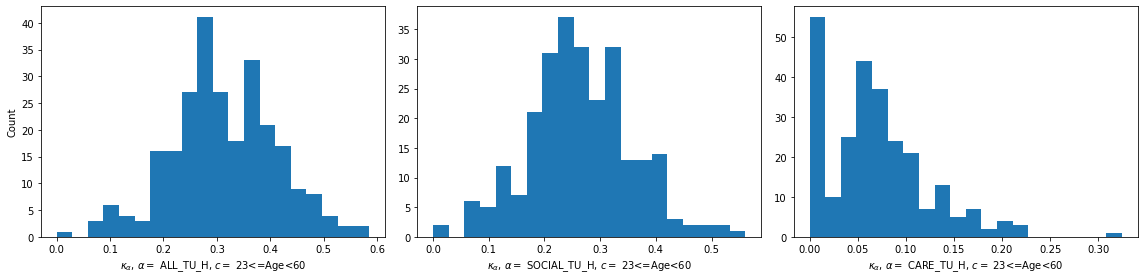

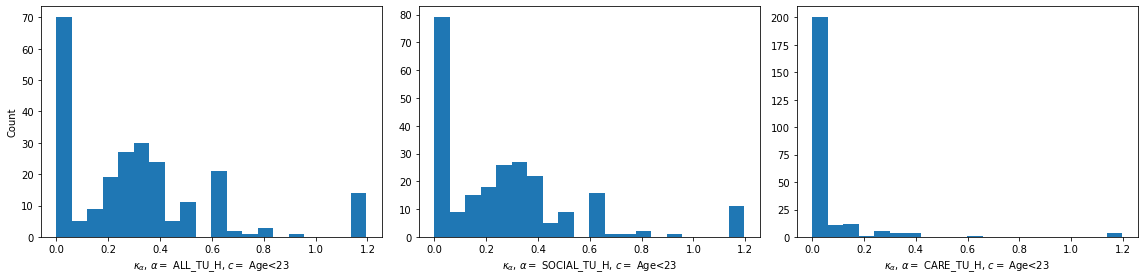

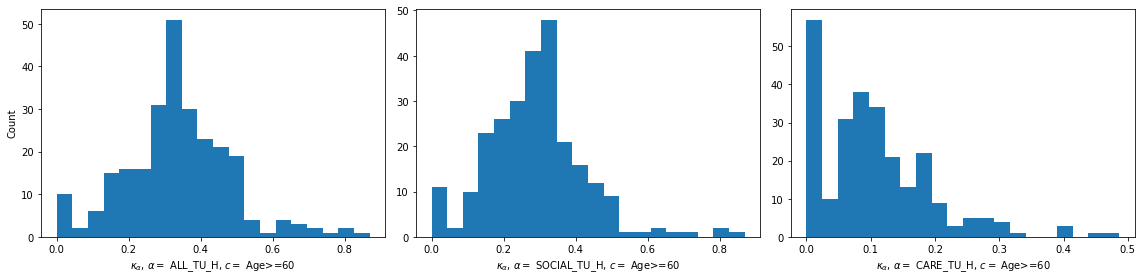

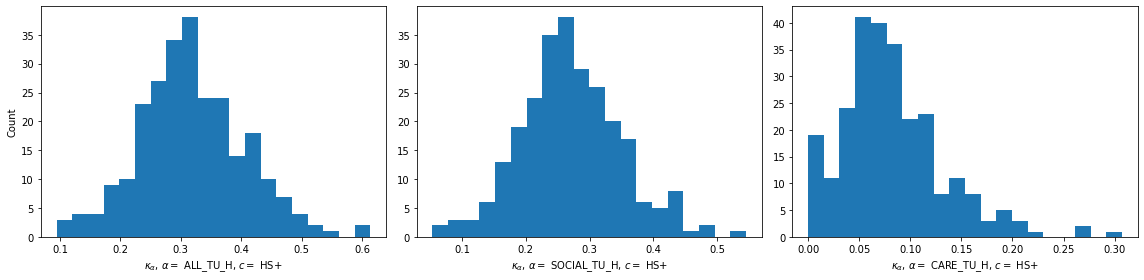

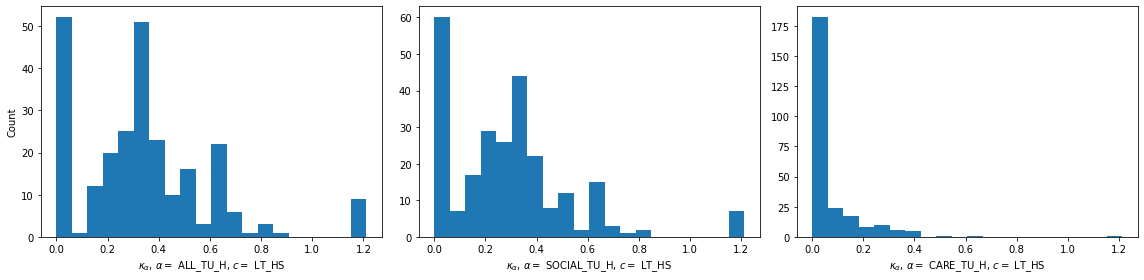

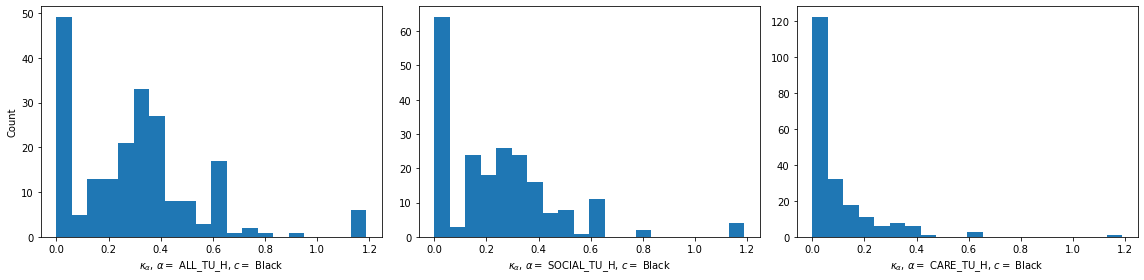

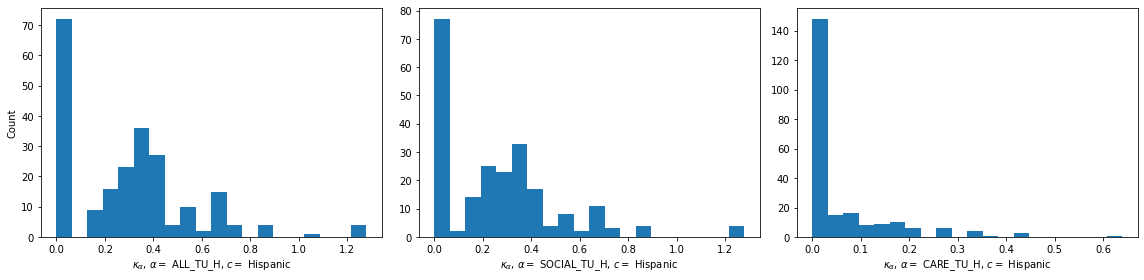

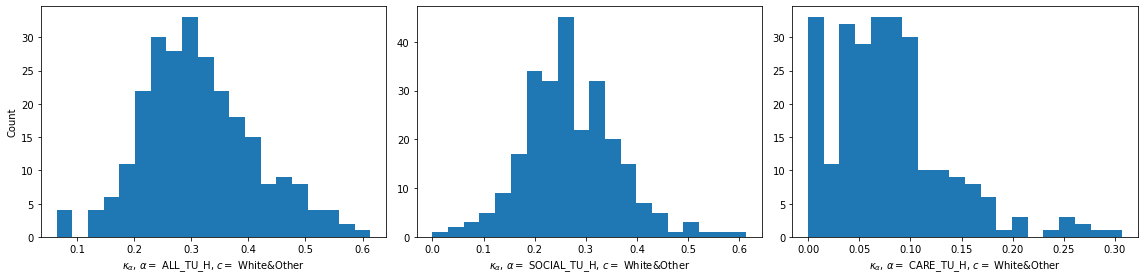

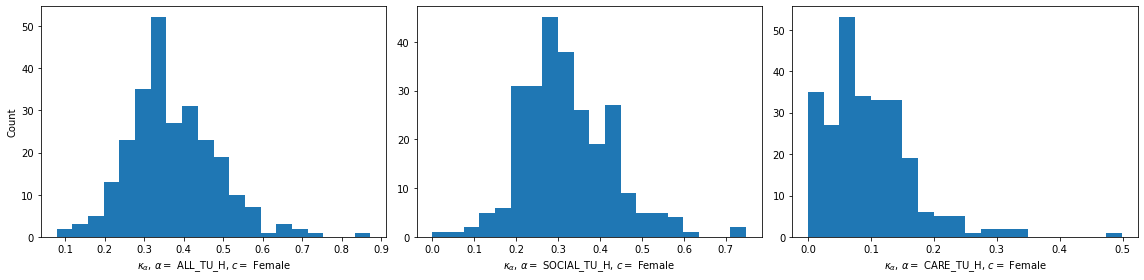

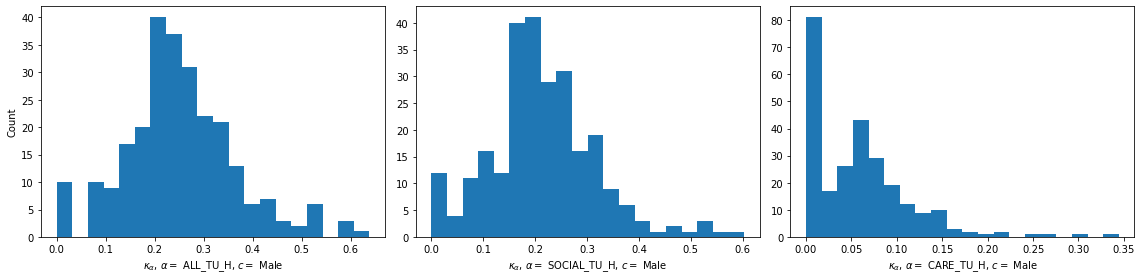

In [566]:
kappa_tilde_df = copy.deepcopy(phi_c_df)
kappa_tilde_df

df_u_gca

c_vars = []
for idx, row in phi_c_df.iterrows():
    a = (row[0], row[1])
    b = (row[2], row[3])
    if a not in c_vars:
        c_vars.append(a)
    if b not in c_vars:
        c_vars.append(b)

c_vars = sorted(c_vars)

# print(c_vars)
# print(len(c_vars))

# May need to swap alpha and c for the other orientation of these variables
for c_class, c_var in c_vars:
    fig, axes = plt.subplots(1,3, figsize=(16,4))
    c = 0
    for alpha in alphas[-3:]:
        pdf = df_pew[df_pew[c_class]==c_var]
        phi_c = pdf['Family Available'].sum()/len(pdf)
        tdf = df_u_gca[df_u_gca[c_class]==c_var]
        tdf = tdf[['GTCBSA',alpha]]
        tdf = tdf.groupby('GTCBSA').mean()
        tdf['kappa'] = tdf[alpha] / phi_c

        axes[c].hist(tdf['kappa'], bins=20)
        axes[c].set_xlabel(f'$\kappa_\\alpha$, $\\alpha=$ {alpha}, $c=$ {c_var}')
        c+=1
    
    axes[0].set_ylabel('Count')
    plt.tight_layout()
    plt.show()

### $v(g|\ell,\hat\ell)$

In [575]:
df_u_gca.head()

TUCASEID  GTCBSA SexClass     RaceEthn    AgeClass EduClass  1_agg_H  \
0  20160101160045   12060   Female  White&Other     Age>=60      HS+      0.0   
1  20160101160069   47900   Female        Black  23<=Age<60      HS+      0.0   
2  20160101160094   33100   Female     Hispanic      Age<23    LT_HS      0.0   
3  20160101160116   35620   Female  White&Other  23<=Age<60      HS+      0.0   
4  20160101160139   17140     Male  White&Other     Age>=60      HS+      0.0   

   10_agg_H  11_agg_H  12_agg_H  ...  7_agg_H  8_agg_H  9_agg_H  ALL_TU_H  \
0       0.0       0.0       1.0  ...      0.0      0.0      0.0       1.0   
1       0.0       0.0       0.0  ...      0.0      0.0      0.0       0.0   
2       0.0       0.0       0.0  ...      0.0      0.0      0.0       0.0   
3       0.0       0.0       0.0  ...      0.0      0.0      0.0       0.0   
4       0.0       0.0       0.0  ...      0.0      0.0      0.0       0.0   

   SOCIAL_TU_H  CARE_TU_H  LONGEST_TRIP_DUR  LONGEST_TRIP_TIER2CODE  Division  \
0          1.0        0.0              15.0                    12.0       5.0   
1          0.0        0.0              30.0                     7.0       5.0   
2          0.0        0.0              10.0                    13.0       5.0   
3          0.0        0.0              20.0                     3.0       2.0   
4          0.0        0.0               5.0                    13.0       3.0   

   TUDIARYDAY  
0         6.0  
1         1.0  
2         1.0  
3         3.0  
4         1.0  

[5 rows x 30 columns]

In [580]:
v_alpha = {}
for alpha in alphas:
    tdf = df_u_gca[[alpha, 'LONGEST_TRIP_DUR']]
    tdf = tdf[tdf['LONGEST_TRIP_DUR']>0]
    tdf = tdf[tdf['LONGEST_TRIP_DUR']<=60]
    v = tdf[alpha].mean()
    v_alpha[alpha] = v
v_alpha

{'1_agg_H': 0.0009115014915478953,
 '10_agg_H': 0.000580046403712297,
 '11_agg_H': 0.1259115014915479,
 '12_agg_H': 0.17438680808750415,
 '13_agg_H': 0.01582698044414982,
 '14_agg_H': 0.014045409347033477,
 '15_agg_H': 0.004971826317533974,
 '16_agg_H': 0.0031902552204176333,
 '18_agg_H': 0.1048641034139874,
 '2_agg_H': 0.05630593304607226,
 '3_agg_H': 0.022331786542923435,
 '4_agg_H': 0.06359794497845542,
 '5_agg_H': 0.008369240967848857,
 '6_agg_H': 0.0014086841233012927,
 '7_agg_H': 0.04023036128604574,
 '8_agg_H': 0.00575903215114352,
 '9_agg_H': 0.0014086841233012927,
 'ALL_TU_H': 0.2564219423268147,
 'SOCIAL_TU_H': 0.21660589990056348,
 'CARE_TU_H': 0.06359794497845542}

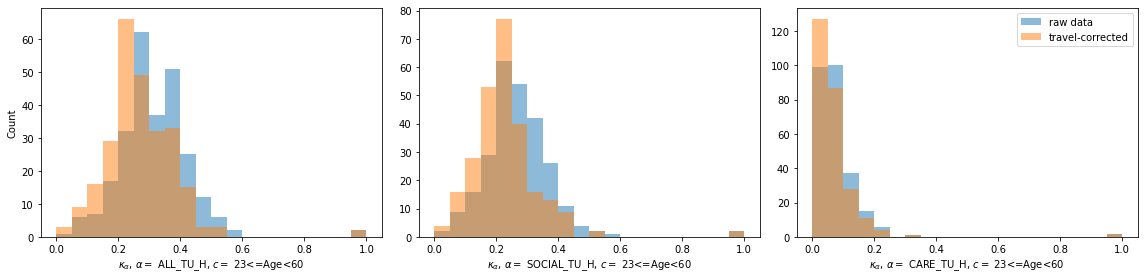

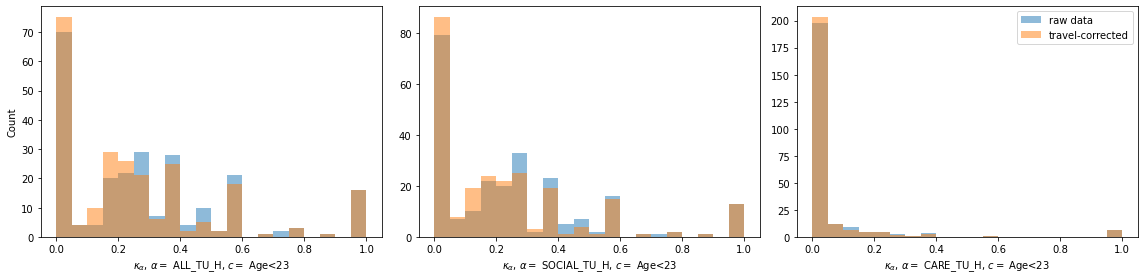

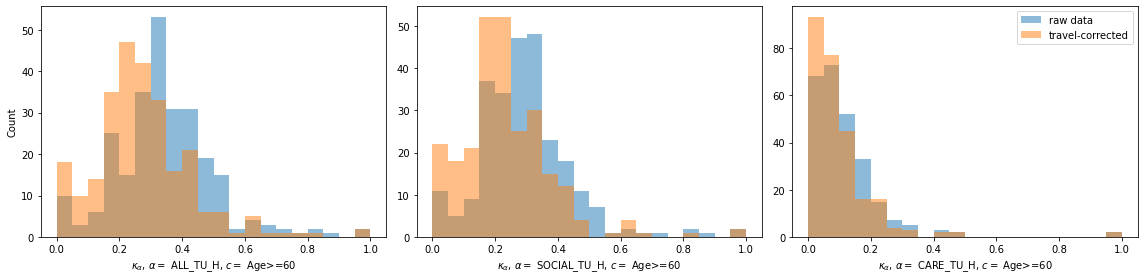

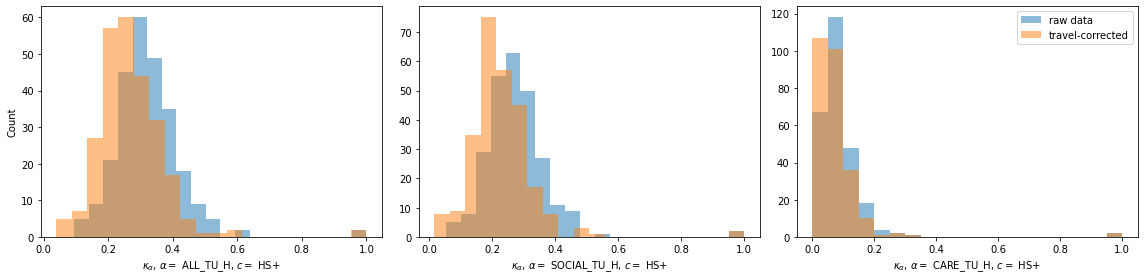

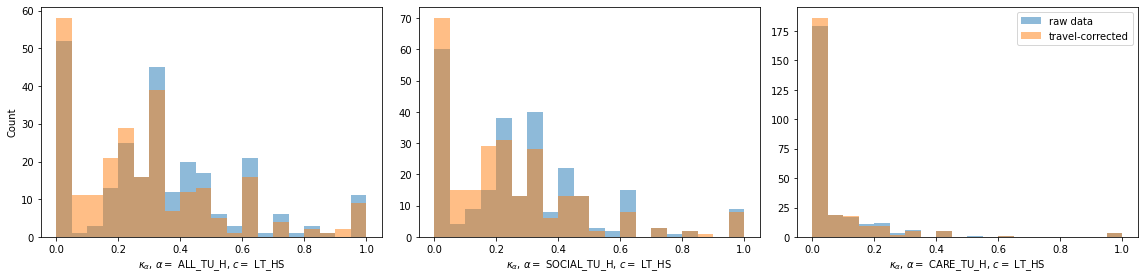

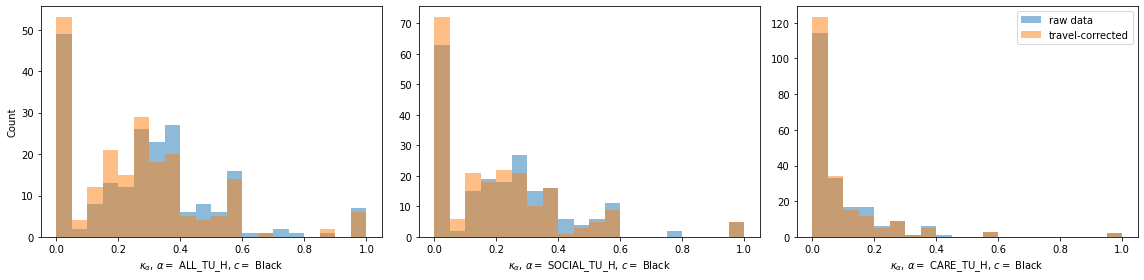

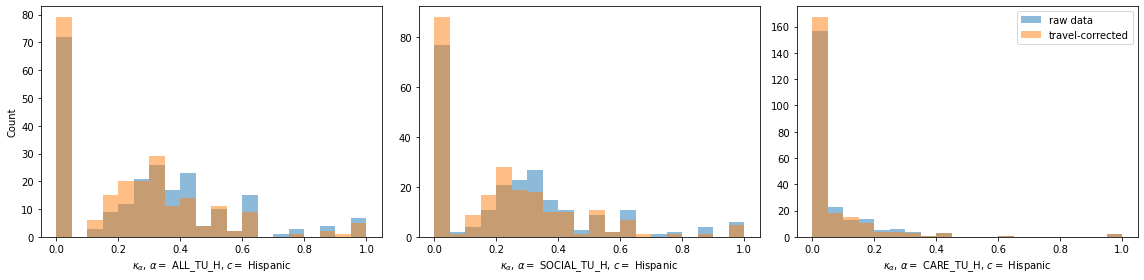

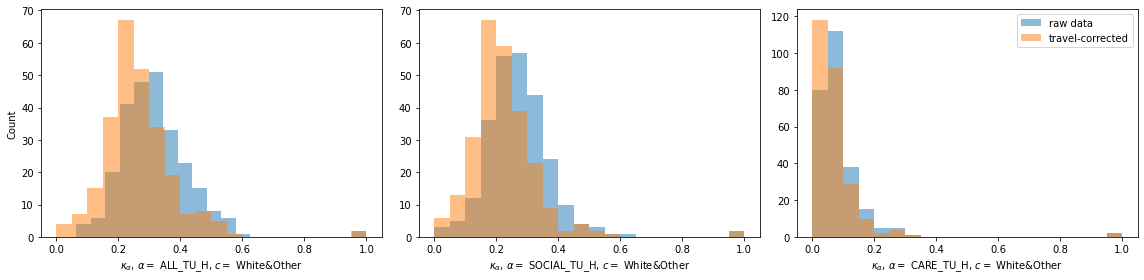

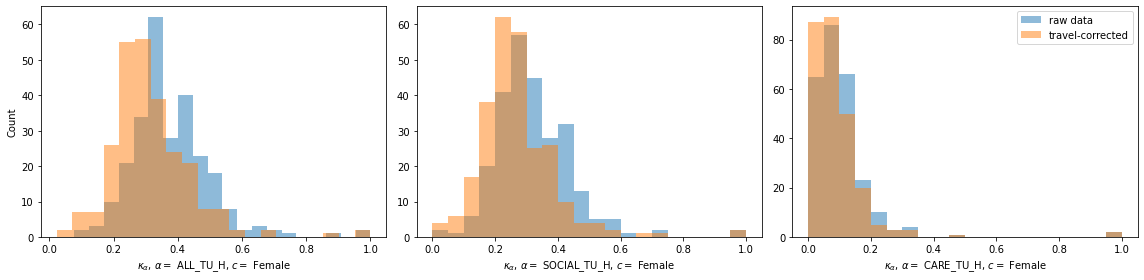

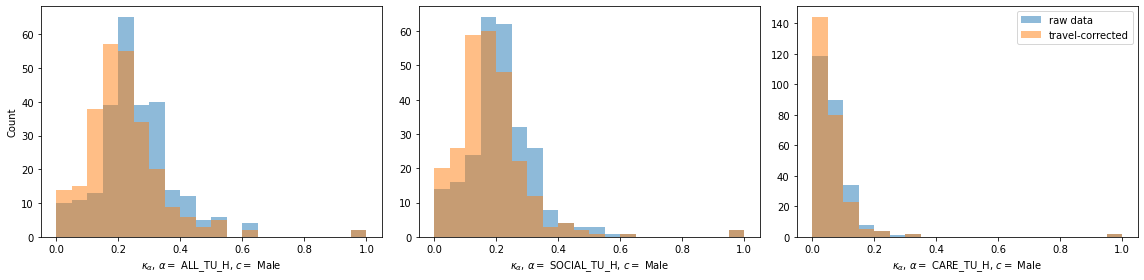

In [605]:
kappa_tilde_df = copy.deepcopy(phi_c_df)
kappa_tilde_df

df_u_gca

c_vars = []
for idx, row in phi_c_df.iterrows():
    a = (row[0], row[1])
    b = (row[2], row[3])
    if a not in c_vars:
        c_vars.append(a)
    if b not in c_vars:
        c_vars.append(b)

c_vars = sorted(c_vars)

def v_correction(x):
    if x > 60:
        return 0
    elif x > 0:
        return 1
    else:
        return v_alpha[alpha]

# print(c_vars)
# print(len(c_vars))

# May need to swap alpha and c for the other orientation of these variables
for c_class, c_var in c_vars:
    fig, axes = plt.subplots(1,3, figsize=(16,4))
    c = 0
    for alpha in alphas[-3:]:
        pdf = df_pew[df_pew[c_class]==c_var]
        phi_c = pdf['Family Available'].sum()/len(pdf)

        tdf = copy.deepcopy(df_u_gca[df_u_gca[c_class]==c_var])
        tdf = tdf[['GTCBSA',alpha, 'LONGEST_TRIP_DUR']]


        # insert v() correction here
        tdf_v = copy.deepcopy(tdf)
        tdf_v['v_corr'] = tdf_v['LONGEST_TRIP_DUR'].apply(v_correction)
        tdf_v[alpha] = tdf_v['v_corr'] * tdf[alpha]

        
        tdf = tdf.groupby('GTCBSA').mean()
        tdf['kappa'] = tdf[alpha] / phi_c
        tdf['kappa'] = tdf['kappa'].apply(lambda x: x if x < 1 else 1)
        axes[c].hist(tdf['kappa'], bins=20, alpha = 0.5, label='raw data')
        axes[c].set_xlabel(f'$\kappa_\\alpha$, $\\alpha=$ {alpha}, $c=$ {c_var}')

        tdf_v = tdf_v.groupby('GTCBSA').mean()
        tdf_v['kappa'] = tdf_v[alpha] / phi_c
        tdf_v['kappa'] = tdf_v['kappa'].apply(lambda x: x if x < 1 else 1)
        axes[c].hist(tdf_v['kappa'], bins=20, alpha=0.5, label='travel-corrected')
        axes[c].set_xlabel(f'$\kappa_\\alpha$, $\\alpha=$ {alpha}, $c=$ {c_var}')

        if tdf_v['kappa'].max() > 1:
            tdf_error = tdf_v[tdf_v['kappa']>1]
            display(tdf_error)

        c+=1
    
    axes[0].set_ylabel('Count')
    plt.tight_layout()
    plt.legend()
    plt.show()

#display(tdf)

### Novel Boxplot Creator

In [674]:
def boxplot_stats(x):
    x = [i for i in x if not (np.isnan(i))]
    x_sort = sorted(x)
    x_25 = x_sort[int(len(x)/4)]
    x_75 = x_sort[int((len(x)/4)*3)]
    iqr_rang = (x_75-x_25)*1.5
    x_outliers = [i for i in x if i<(x_25-iqr_rang) or i>(x_75+iqr_rang)]
    return [max(min(x), x_25-iqr_rang), 
                x_25, 
                sum(x)/len(x), 
                x_75, 
                min(max(x), x_75+iqr_rang), 
                x_outliers]

([<matplotlib.axis.YTick at 0x186971b20>,
 [Text(0, 0.3333333333333333, 'f_all'),
  Text(0, 0.6666666666666666, 'f_social'),
  Text(0, 1.0, 'f_care')])

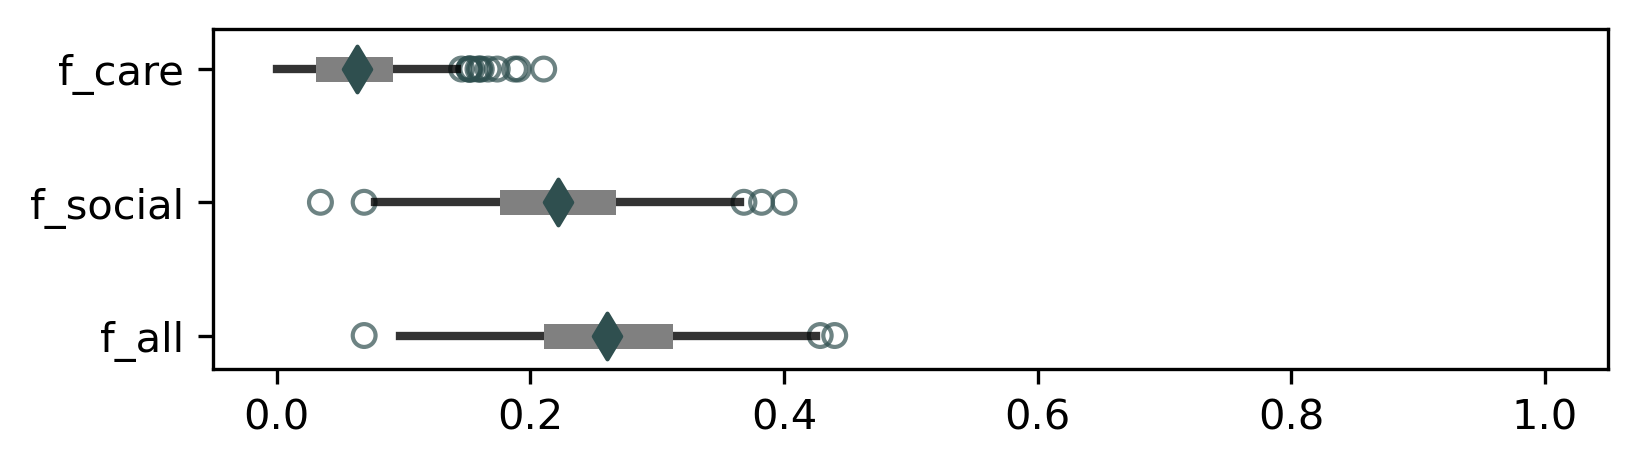

In [685]:
df_g = copy.deepcopy(df_u_gca.groupby('GTCBSA').mean())
f_all = df_g['ALL_TU_H'].tolist()
f_social = df_g['SOCIAL_TU_H'].tolist()
f_care = df_g['CARE_TU_H'].tolist()

vars = [f_all, f_social, f_care]
var_strs = ['f_all', 'f_social', 'f_care']
ys = []
plt.figure(figsize=(6,1.5), dpi=300)
for idx, array in enumerate(vars):
    y = (idx+1) / len(vars)
    s = boxplot_stats(array)

    plt.scatter([s[2]], [y], s=60, c='darkslategrey', marker='d', zorder=4)
    if len(s[5]) > 0:
        plt.scatter(s[5], [y for i in range(len(s[5]))], s=30, facecolors='none', edgecolors='darkslategrey', marker='o', zorder=1, alpha=0.7)
    plt.plot([s[0],s[4]], [y,y], linewidth=2, c='black',zorder=2, alpha=0.8)
    plt.plot([s[1],s[3]], [y,y], linewidth=6, c='grey',zorder=3)
    ys.append(y)
plt.ylim(0.25, 1.1)
plt.xlim(-0.05, 1.05)
plt.yticks(ys, var_strs)



### The $\phi$'s and their $\kappa$'s

$\langle \phi \rangle = $ average $\phi(g)$   
$\phi(g)$ = average $\phi$ for a given $g$  
$\phi(c)$ = average $\phi$ for each characteristic  
$\phi(g,c)$ = average $\phi$ for each characteristic in each city  
$\tilde\phi(g,c,a)$ = $\phi$ model for each activity, city, and characteristic  

    - Avg all phi: kappa(alpha) (relates to activity but c is averaged out)
    - f(g|alpha)/phi(g) = kappa(g | alpha)
    - phi_tilde model = kappa(g, c, alpha) (there might be a population related correction possible if this goes haywire)

DO MODEL 3 first

model 1 is Eq 45; homegeneity assumption model

p(x) is actual people meeting the condition

eq 55 has phi_tilde (g,c)

measures to do:
 - model 2 (footnote) is eq 63; the right hand side of this might be a good test agains the left hand side directly
 - model 2 (correct): average $\kappa$ - 4.2, eq 64 (k(c,g,a) is 62 and 52)
 - model 3 (eq 62 and 52)

phi(g) vs. under-tilde phi(g) is a good test to do; do this one if possible

In [720]:
df_u_gca_weight = df_resp_weight.merge(df_u_gca, on='TUCASEID', how='left')
# display(df_u_gca_weight.head(3))
# display(df_pew.head(3))
# display(phi_c_df.head(3))

In [711]:
df_tus_trunc = df_u_gca_weight[df_u_gca_weight['GTCBSA'].isin(df_pew['GTCBSA'].tolist())]
df_pew_trunc = df_pew[df_pew['GTCBSA'].isin(df_tus_trunc['GTCBSA'].tolist())]

print(df_tus_trunc.shape)
display(df_tus_trunc.head(3))
print(df_pew_trunc.shape)
display(df_pew_trunc.head(3))

(30454, 31)


TUCASEID  NEW_WEIGHT  GTCBSA SexClass     RaceEthn    AgeClass  \
0  20160101160045     20976.0   12060   Female  White&Other     Age>=60   
1  20160101160069     18319.0   47900   Female        Black  23<=Age<60   
2  20160101160094     57019.0   33100   Female     Hispanic      Age<23   

  EduClass  1_agg_H  10_agg_H  11_agg_H  ...  7_agg_H  8_agg_H  9_agg_H  \
0      HS+      0.0       0.0       0.0  ...      0.0      0.0      0.0   
1      HS+      0.0       0.0       0.0  ...      0.0      0.0      0.0   
2    LT_HS      0.0       0.0       0.0  ...      0.0      0.0      0.0   

   ALL_TU_H  SOCIAL_TU_H  CARE_TU_H  LONGEST_TRIP_DUR  LONGEST_TRIP_TIER2CODE  \
0       1.0          1.0        0.0              15.0                    12.0   
1       0.0          0.0        0.0              30.0                     7.0   
2       0.0          0.0        0.0              10.0                    13.0   

   Division  TUDIARYDAY  
0       5.0         6.0  
1       5.0         1.0  
2       5.0         1.0  

[3 rows x 31 columns]

(1713, 19)


msa        state  FIPS   GTCBSA     sex q7_family_members  NO family  \
0  14860  Connecticut  9001  14860.0  Female              None          1   
1  13820      Alabama  1115  13820.0  Female         1 up to 5          0   
2  13820      Alabama  1021  13820.0  Female      More than 20          0   

   Family Available age      Education income_short recage  racethn    weight  \
0                 0  44   some_college       10-20k  35-44  White~H  3.547619   
1                 1  49     highschool       10-20k  45-54  Black~H  2.250000   
2                 1  74  lt_highschool       10-20k    65+  White~H  2.523810   

   weighted_f    AgeClass SexClass     RaceEthn EduClass  
0     0.00000  23<=Age<60   Female  White&Other      HS+  
1     2.25000  23<=Age<60   Female        Black      HS+  
2     2.52381     Age>=60   Female  White&Other    LT_HS

### Updated $v(g)_{t= 0<\ell<\hat\ell}$

In [735]:
v_alpha = {}
for alpha in alphas:
    tdf = copy.deepcopy(df_u_gca_weight[[alpha, 'LONGEST_TRIP_DUR', 'NEW_WEIGHT', 'TUDIARYDAY']])
    tdf[alpha] = tdf[alpha]*tdf['NEW_WEIGHT']
    tdf = tdf[tdf['LONGEST_TRIP_DUR']>0]
    tdf = tdf[tdf['LONGEST_TRIP_DUR']<=60]
    v = tdf[alpha].sum() / tdf['NEW_WEIGHT'].sum()
    v_alpha[alpha] = v

v_alpha_we = {}
for alpha in alphas:
    tdf = copy.deepcopy(df_u_gca_weight[[alpha, 'LONGEST_TRIP_DUR', 'NEW_WEIGHT', 'TUDIARYDAY']])
    tdf = tdf[tdf['TUDIARYDAY'].isin([1,7])]
    tdf[alpha] = tdf[alpha]*tdf['NEW_WEIGHT']
    tdf = tdf[tdf['LONGEST_TRIP_DUR']>0]
    tdf = tdf[tdf['LONGEST_TRIP_DUR']<=60]
    v = tdf[alpha].sum() / tdf['NEW_WEIGHT'].sum()
    v_alpha_we[alpha] = v

v_alpha_wd = {}
for alpha in alphas:
    tdf = copy.deepcopy(df_u_gca_weight[[alpha, 'LONGEST_TRIP_DUR', 'NEW_WEIGHT', 'TUDIARYDAY']])
    tdf = tdf[~tdf['TUDIARYDAY'].isin([1,7])]
    tdf[alpha] = tdf[alpha]*tdf['NEW_WEIGHT']
    tdf = tdf[tdf['LONGEST_TRIP_DUR']>0]
    tdf = tdf[tdf['LONGEST_TRIP_DUR']<=60]
    v = tdf[alpha].sum() / tdf['NEW_WEIGHT'].sum()
    v_alpha_wd[alpha] = v

v_alpha
v_alpha_wd
v_alpha_we

{'1_agg_H': 0.0006897658187920194,
 '10_agg_H': 0.00025046506666597727,
 '11_agg_H': 0.17251322969262753,
 '12_agg_H': 0.22451974681573658,
 '13_agg_H': 0.023893310704737478,
 '14_agg_H': 0.022911648859557317,
 '15_agg_H': 0.00580321464142275,
 '16_agg_H': 0.004440102921795799,
 '18_agg_H': 0.12630509138932244,
 '2_agg_H': 0.07129856841616186,
 '3_agg_H': 0.02437719779847812,
 '4_agg_H': 0.06734667466582492,
 '5_agg_H': 0.005590103728042275,
 '6_agg_H': 0.0019771616309075223,
 '7_agg_H': 0.051201954401118875,
 '8_agg_H': 0.0033187590817699486,
 '9_agg_H': 0.0011639613824344563,
 'ALL_TU_H': 0.3108413568944241,
 'SOCIAL_TU_H': 0.27677396804635573,
 'CARE_TU_H': 0.06734667466582492}

### Updated $f(g|\alpha)$ using new $v(g)$

In [752]:
f_alpha_dict = {}

for alpha, v in v_alpha.items():
    tdf = copy.deepcopy(df_tus_trunc[['TUCASEID','NEW_WEIGHT','GTCBSA', alpha, 'LONGEST_TRIP_DUR', 'TUDIARYDAY']])
    v_score = v_alpha[alpha]
    tdf['within_ell'] = tdf['LONGEST_TRIP_DUR'].apply(lambda x: 1 if x > 0 and x <=60 else 0)
    tdf['incoming_trav'] = tdf['LONGEST_TRIP_DUR'].apply(lambda x: v_score if np.isnan(x) else 0)
    tdf['personal_f'] = tdf['NEW_WEIGHT'] * tdf[alpha] * (tdf['within_ell'] + tdf['incoming_trav'])

    tdf_cbsa = tdf.groupby('GTCBSA').mean()
    tdf_cbsa['personal_f'] = tdf_cbsa['personal_f'] / tdf_cbsa['NEW_WEIGHT']
    tdf_cbsa = tdf_cbsa.reset_index()
    tdf_cbsa[alpha] = tdf_cbsa['personal_f']
    f_alpha_dict[alpha] = tdf_cbsa[['GTCBSA',alpha]]
    #isplay(f_alpha_dict[alpha])

f_alpha_dict[alpha]

GTCBSA  CARE_TU_H
0     10420   0.001120
1     10580   0.034978
2     10740   0.051694
3     10900   0.060323
4     11100   0.050613
..      ...        ...
221   49180   0.109400
222   49340   0.066185
223   49620   0.049969
224   49660   0.081610
225   49740   0.080595

[226 rows x 2 columns]

### $\langle \phi(g) \rangle$ & $\kappa(g)$ estimate from $f(g)/ \langle \phi(g) \rangle$

GTCBSA  Family Available     weight  count  weighted_availability  \
0    10420.0                 1   2.534984      2               1.264151   
1    10580.0                 4   9.570811      5               7.193452   
2    10740.0                 2  10.194856      5               3.835580   
3    10900.0                 2  10.053908      4               6.904762   
4    11100.0                 1   1.458333      1               1.458333   
..       ...               ...        ...    ...                    ...   
221  49180.0                 4   9.350460      4               9.350460   
222  49340.0                 5   9.644261      5               9.644261   
223  49620.0                 2   5.276786      2               5.276786   
224  49660.0                 4   6.895833      4               6.895833   
225  49740.0                 1   5.571429      2               4.333333   

        phi_g  ALL_TU_H   kappa_g  
0    0.394480  0.252601  0.640339  
1    0.417937  0.193334  0.462591  
2    0.196177  0.221343  1.000000  
3    0.198928  0.185650  0.933255  
4    0.685714  0.266585  0.388770  
..        ...       ...       ...  
221  0.427786  0.324002  0.757391  
222  0.518443  0.177364  0.342110  
223  0.379019  0.235730  0.621949  
224  0.580060  0.309181  0.533015  
225  0.179487  0.354870  1.000000  

[215 rows x 8 columns]

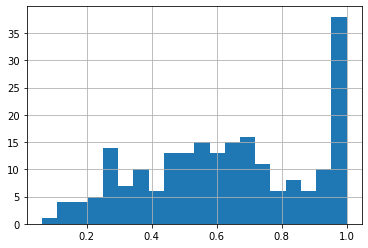

In [774]:
df_phi_g = copy.deepcopy(df_pew_trunc[['GTCBSA','Family Available', 'weight']])
df_phi_g['count'] = 1
df_phi_g['weighted_availability'] = df_phi_g['Family Available']* df_phi_g['weight']
df_phi_g = df_phi_g.groupby('GTCBSA').sum()
df_phi_g['phi_g'] = df_phi_g['Family Available'] / df_phi_g['weight']
df_phi_g = df_phi_g.reset_index()
df_phi_g = df_phi_g.merge(f_alpha_dict['ALL_TU_H'], on='GTCBSA', how='inner')
df_phi_g = df_phi_g[df_phi_g['phi_g']>0]
df_phi_g['kappa_g'] = df_phi_g['ALL_TU_H'] / df_phi_g['phi_g']
df_phi_g['kappa_g'] = df_phi_g['kappa_g'].apply(lambda x: x if x < 1 else 1)


df_phi_g[df_phi_g['count']>0]['kappa_g'].hist(bins=20)

df_phi_g

### $ f(g, c) / \langle \tilde\phi(g,c)\rangle$

In [791]:
n_bins = 6

cbsa_pop_df = copy.deepcopy(df_cbsa)
cbsa_pop_df = cbsa_pop_df[cbsa_pop_df['GTCBSA'].isin(df_tus_trunc['GTCBSA'].tolist())]
cbsa_pop_df['pop_bin'] = pd.cut(cbsa_pop_df['LOG_POP'], n_bins,)
cbsa_pop_df

cbsa_bins = copy.deepcopy(cbsa_pop_df[['GTCBSA','pop_bin']])
df_pew_trunc_p_bins = copy.deepcopy(df_pew_trunc)
df_pew_trunc_p_bins = cbsa_bins.merge(df_pew_trunc_p_bins, on='GTCBSA', how='right')
df_pew_trunc_p_bins

c_phis = {}

for col in ['AgeClass', 'SexClass','RaceEthn', 'EduClass']:
    tdf = copy.deepcopy(df_pew_trunc_p_bins)
    tdf = tdf[~tdf[col].isna()]
    c_phis[col] = {}
    for var in tdf[col].unique():
        t_phi = tdf[tdf[col]==var]['Family Available'].mean()
        #print(col, var, t_phi)
        c_phis[col][var] = t_phi
c_phis

{'AgeClass': {'23<=Age<60': 0.7898832684824902,
  'Age>=60': 0.8016701461377871,
  'Age<23': 0.8273381294964028},
 'SexClass': {'Female': 0.782312925170068, 'Male': 0.8098676293622142},
 'RaceEthn': {'White&Other': 0.7908242612752722,
  'Black': 0.8217821782178217,
  'Hispanic': 0.785},
 'EduClass': {'HS+': 0.7965779467680608, 'LT_HS': 0.7890625}}

In [1392]:
alpha = 'ALL_TU_H'

dfs = []

for col, val in c_phis.items():
    tdf = copy.deepcopy(df_tus_trunc[['TUCASEID','NEW_WEIGHT','GTCBSA', alpha, col, 'LONGEST_TRIP_DUR', 'TUDIARYDAY']])
    for var, phi in val.items():
        ttdf = copy.deepcopy(tdf)
        ttdf = ttdf[ttdf[col]==var]
        v_score = v_alpha[alpha]
        ttdf['within_ell'] = ttdf['LONGEST_TRIP_DUR'].apply(lambda x: 1 if x > 0 and x <=60 else 0)
        ttdf['incoming_trav'] = ttdf['LONGEST_TRIP_DUR'].apply(lambda x: v_score if np.isnan(x) else 0)
        ttdf['f_'+var] = ttdf['NEW_WEIGHT'] * ttdf[alpha] * (ttdf['within_ell'] + ttdf['incoming_trav'])

        tdf_cbsa = ttdf.groupby('GTCBSA').mean()
        tdf_cbsa['f_'+var] = tdf_cbsa['f_'+var] / tdf_cbsa['NEW_WEIGHT']
        tdf_cbsa = tdf_cbsa.reset_index()
        tdf_cbsa[alpha] = tdf_cbsa['f_'+var]
        tdf_cbsa['phi_g_'+var] = tdf_cbsa['f_'+var] / c_phis[col][var]
        tdf_cbsa['phi_g_'+var] = tdf_cbsa['phi_g_'+var].apply(lambda x: x if x<1 else 1)

        tdf_cbsa = tdf_cbsa[['GTCBSA', 'f_'+var, 'phi_g_'+var]]
        dfs.append(tdf_cbsa)

phi_gc_f_gc_df = dfs[0]

for tdf in dfs[1:]:
    phi_gc_f_gc_df = phi_gc_f_gc_df.merge(tdf, on='GTCBSA', how='left')

phi_gc_f_gc_df
        

GTCBSA  f_23<=Age<60  phi_g_23<=Age<60  f_Age>=60  phi_g_Age>=60  \
0     10420      0.161470          0.204422   0.247671       0.308944   
1     10580      0.152609          0.193204   0.396267       0.494301   
2     10740      0.265619          0.336276   0.305571       0.381168   
3     10900      0.271031          0.343128   0.228073       0.284497   
4     11100      0.260104          0.329294   0.338951       0.422806   
..      ...           ...               ...        ...            ...   
221   49180      0.429269          0.543458   0.358000       0.446568   
222   49340      0.247769          0.313678   0.155252       0.193660   
223   49620      0.329824          0.417560   0.274140       0.341962   
224   49660      0.505921          0.640501   0.116487       0.145305   
225   49740      0.351183          0.444602   0.515760       0.643357   

     f_Age<23  phi_g_Age<23  f_Female  phi_g_Female    f_Male  ...  \
0    1.058678      1.000000  0.316136      0.404104  0.298625  ...   
1    0.244246      0.295219  0.280736      0.358854  0.194724  ...   
2    0.267531      0.323364  0.361498      0.462089  0.188126  ...   
3    0.081719      0.098774  0.258011      0.329806  0.211198  ...   
4    1.247195      1.000000  0.413817      0.528966  0.258401  ...   
..        ...           ...       ...           ...       ...  ...   
221  0.314068      0.379613  0.533190      0.681556  0.232129  ...   
222  0.218922      0.264610  0.222105      0.283907  0.214536  ...   
223  0.182617      0.220728  0.437835      0.559667  0.139623  ...   
224  0.448270      0.541822  0.361613      0.462235  0.368940  ...   
225  0.704307      0.851293  0.347197      0.443808  0.537077  ...   

     f_White&Other  phi_g_White&Other   f_Black  phi_g_Black  f_Hispanic  \
0         0.311683           0.394124  0.381089     0.463735    0.000000   
1         0.228121           0.288460  0.233492     0.284129    0.670862   
2         0.206590           0.261234  0.147877     0.179947    0.364637   
3         0.243122           0.307428  0.000000     0.000000    0.219931   
4         0.271766           0.343649  0.000000     0.000000    0.597160   
..             ...                ...       ...          ...         ...   
221       0.445970           0.563931  0.152392     0.185440    0.400170   
222       0.192146           0.242969  0.351834     0.428136    0.399050   
223       0.299496           0.378713  0.595803     0.725013    0.051562   
224       0.324575           0.410427  0.888027     1.000000    0.000000   
225       0.434834           0.549848       NaN          NaN    0.449694   

     phi_g_Hispanic     f_HS+  phi_g_HS+   f_LT_HS  phi_g_LT_HS  
0          0.000000  0.321705   0.403859  0.181683     0.230252  
1          0.854601  0.247432   0.310618  0.177491     0.224939  
2          0.464506  0.265336   0.333095  0.338333     0.428778  
3          0.280167  0.247799   0.311079  0.000000     0.000000  
4          0.760714  0.347115   0.435758  0.000000     0.000000  
..              ...       ...        ...       ...          ...  
221        0.509771  0.406193   0.509923  0.319522     0.404939  
222        0.508344  0.213519   0.268045  0.246742     0.312703  
223        0.065684  0.297839   0.373898  0.243948     0.309161  
224        0.000000  0.391182   0.491078  0.178649     0.226407  
225        0.572859  0.313588   0.393669  0.735193     0.931730  

[226 rows x 21 columns]

### $\tilde\kappa(c,g,\alpha)$ & $\utilde\kappa(c,g,\alpha)$

### Equation 62 (Model 3)
$$\utilde{\kappa}(g,\mathbf{c},\alpha)=\frac{u(g,\mathbf{c},\alpha)}{\langle\phi(\mathbf{c}|p(g))\rangle}=\frac{\sum_{i\in g}a(i|\alpha)\delta_{\mathbf{c},\mathbf{c}(i)}}{s(g,\mathbf{c})\langle\phi(\mathbf{c}|p(g))\rangle}$$

### Equation 52 (Model 3)
$$\tilde{\kappa}(g,\mathbf{c},\alpha)=\frac{u(g,\mathbf{c},\alpha)}{\langle\phi(\mathbf{c})\rangle}=\frac{\sum_{i\in g}a(i|\alpha)\delta_{\mathbf{c},\mathbf{c}(i)}}{s(g,\mathbf{c})\langle\phi(\mathbf{c})\rangle}$$

### Equation 64 (Model 2)
$$\kappa(g,\alpha)=\frac{\sum_{\mathbf{c}}\kappa(g,\mathbf{c},\alpha)p(g,\mathbf{c})}{p(g)}=\frac{\sum_{\mathbf{c}}\kappa(g,\mathbf{c},\alpha)p(g,\mathbf{c})}{\sum_{\mathbf{c}}p(g,\mathbf{c})}$$


$\langle \phi \rangle = $ average $\phi(g)$   
$\phi(g)$ = average $\phi$ for a given $g$  
$\phi(c)$ = average $\phi$ for each characteristic  
$\phi(g,c)$ = average $\phi$ for each characteristic in each city  
$\tilde\phi(g,c,a)$ = $\phi$ model for each activity, city, and characteristic  

    - Avg all phi: kappa(alpha) (relates to activity but c is averaged out)
    - f(g|alpha)/phi(g) = kappa(g | alpha)
    - phi_tilde model = kappa(g, c, alpha) (there might be a population related correction possible if this goes haywire)

DO MODEL 3 first

model 1 is Eq 45; homegeneity assumption model

p(x) is actual people meeting the condition

eq 55 has phi_tilde (g,c)

measures to do:
 - model 2 (footnote) is eq 63; the right hand side of this might be a good test agains the left hand side directly
 - model 2 (correct): average $\kappa$ - 4.2, eq 64 (k(c,g,a) is 62 and 52)
 - model 3 (eq 62 and 52)

phi(g) vs. under-tilde phi(g) is a good test to do; do this one if possible

In [816]:
df_pew_trunc_p_bins.groupby('pop_bin')['GTCBSA'].nunique()

pop_bin
(4.958, 5.348]    51
(5.348, 5.737]    77
(5.737, 6.125]    56
(6.125, 6.513]    25
(6.513, 6.902]    14
(6.902, 7.29]      3
Name: GTCBSA, dtype: int64

### EQ-52: $\tilde\kappa(g,c,a)$

In [892]:
# # EQ 52 no g used

# phi_c_expected = c_phis # previously calculated

# alphas, cs, c_var, kappas = [],[],[],[]

# for alpha, _ in v_alpha.items():
# #alpha = 'ALL_TU_H'
#     for col, val in c_phis.items():
#         tdf = copy.deepcopy(df_tus_trunc[['TUCASEID','NEW_WEIGHT','GTCBSA', alpha, col, 'LONGEST_TRIP_DUR', 'TUDIARYDAY']])
#         for var, phi in val.items():
#             ttdf = copy.deepcopy(tdf[tdf[col]==var])
#             s = len(ttdf)

#             # TRAVEL CORRECTION LOGIC
#             ttdf['within_ell'] = ttdf['LONGEST_TRIP_DUR'].apply(lambda x: 1 if x > 0 and x <=60 else 0)
#             ttdf['incoming_trav'] = ttdf['LONGEST_TRIP_DUR'].apply(lambda x: v_score if  np.isnan(x)  else 0)
#             ttdf[alpha] = ttdf[alpha] * (ttdf['within_ell']+ttdf['incoming_trav'])
#             # END TRAVEL CORRECTION LOGIC

#             kappa_tilde_gca = sum(ttdf[alpha]) / (s*phi_c_expected[col][var])
#             alphas.append(alpha)
#             cs.append(col)
#             c_var.append(var)
#             kappas.append(kappa_tilde_gca)

# kappa_tilde_gca_df = pd.DataFrame({'alpha':alphas, 
#                                     'c_type':cs,
#                                     'c':c_var,
#                                     'kappa_tilde(gca)':kappas})

# kappa_tilde_gca_df = kappa_tilde_gca_df.pivot_table(values=['kappa_tilde(gca)'], index='alpha', columns=['c_type', 'c'])
# kappa_tilde_gca_df

In [922]:
# # EQ 52 - # \tilde\kappa(g,c,a) (single c)
# # 

# phi_c_expected = c_phis # previously calculated

# alphas, cbsas, cs, c_var, kappas = [],[],[],[],[]

# alphas_dict = {}

# for alpha, _ in v_alpha.items():
# #alpha = 'ALL_TU_H'
#     for col, val in phi_c_expected.items():
#         tdf = copy.deepcopy(df_tus_trunc[['TUCASEID','NEW_WEIGHT','GTCBSA', alpha, col, 'LONGEST_TRIP_DUR', 'TUDIARYDAY']])
#         for var, phi in val.items():
#             ttdf = copy.deepcopy(tdf[tdf[col]==var])
            
#             # TRAVEL CORRECTION LOGIC
#             ttdf['within_ell'] = ttdf['LONGEST_TRIP_DUR'].apply(lambda x: 1 if x > 0 and x <=60 else 0)
#             ttdf['incoming_trav'] = ttdf['LONGEST_TRIP_DUR'].apply(lambda x: v_score if  np.isnan(x) < 1 else 0)
#             ttdf[alpha] = ttdf[alpha] * (ttdf['within_ell']+ttdf['incoming_trav'])
#             # END TRAVEL CORRECTION LOGIC

#             for cbsa in ttdf['GTCBSA'].unique():
#                 tttdf = ttdf[ttdf['GTCBSA']==cbsa]
#                 s = len(tttdf)
#                 kappa_tilde_gca = sum(tttdf[alpha]) / (s*phi_c_expected[col][var])
#                 cbsas.append(cbsa)
#                 alphas.append(alpha)
#                 #cs.append(col)
#                 c_var.append(var)
#                 kappas.append(kappa_tilde_gca)

# kappa_tilde_gca_df = pd.DataFrame({'alpha':alphas, 
#                                     #'c_type':cs,
#                                     'GTCBSA':cbsas,
#                                     'c':c_var,
#                                     'kappa_tilde(gca)':kappas})

# kappa_tilde_gca_df = kappa_tilde_gca_df.pivot_table(values=['kappa_tilde(gca)'], index=['alpha','GTCBSA' ], columns=['c'])

In [958]:
phi_c_expected

{'AgeClass': {'23<=Age<60': 0.7898832684824902,
  'Age>=60': 0.8016701461377871,
  'Age<23': 0.8273381294964028},
 'SexClass': {'Female': 0.782312925170068, 'Male': 0.8098676293622142},
 'RaceEthn': {'White&Other': 0.7908242612752722,
  'Black': 0.8217821782178217,
  'Hispanic': 0.785},
 'EduClass': {'HS+': 0.7965779467680608, 'LT_HS': 0.7890625}}

In [968]:
# # EQ 52 - # \tilde\kappa(g,c,a) (dual c)

phi_c_expected = c_phis # previously calculated
phi_c_df

alphas, cbsas,  c_var, c_var2, kappas = [],[],[],[],[]

alphas_dict = {}

for alpha, _ in v_alpha.items():
    #for col, val in phi_c_expected.items():

    for idx, row in phi_c_df.iterrows():
        col1 = row['class1_type']
        col2 = row['class2_type']
        var1 = row['class1']
        var2 = row['class2']
        r_phi_c = row['phi_c']

        #print(col1, col2, var1, var2)
    
        tdf = df_tus_trunc[['TUCASEID','NEW_WEIGHT','GTCBSA', alpha, col1, col2, 'LONGEST_TRIP_DUR', 'TUDIARYDAY']]
        #for var, phi in val.items():
        ttdf = tdf[tdf[col1]==var1]
        ttdf = ttdf[ttdf[col2]==var2].copy()
        
        # TRAVEL CORRECTION LOGIC
        ttdf['within_ell'] = ttdf['LONGEST_TRIP_DUR'].apply(lambda x: 1 if x > 0 and x <=60 else 0)
        ttdf['incoming_trav'] = ttdf['LONGEST_TRIP_DUR'].apply(lambda x: v_score if  np.isnan(x) else 0)
        ttdf[alpha] = ttdf[alpha] * (ttdf['within_ell']+ttdf['incoming_trav'])
        # END TRAVEL CORRECTION LOGIC

        for cbsa in ttdf['GTCBSA'].unique():
            tttdf = ttdf[ttdf['GTCBSA']==cbsa]
            s = len(tttdf)
            kappa_tilde_gca = sum(tttdf[alpha]) / (s*r_phi_c)
            cbsas.append(cbsa)
            alphas.append(alpha)
            #cs.append(col)
            c_var.append(var1)
            c_var2.append(var2)
            kappas.append(kappa_tilde_gca)

kappa_tilde_gca_df = pd.DataFrame({'alpha':alphas, 
                                    #'c_type':cs,
                                    'GTCBSA':cbsas,
                                    'c1':c_var,
                                    'c2':c_var2,
                                    'kappa_tilde(gca)':kappas})

kappa_tilde_gca_df = kappa_tilde_gca_df.pivot_table(values=['kappa_tilde(gca)'], index=['alpha','GTCBSA' ], columns=['c1','c2'])

In [969]:
kappa_gca_v1 = kappa_tilde_gca_df.copy()
kappa_gca_v1 = kappa_gca_v1.reset_index()
cols = kappa_gca_v1.columns.to_flat_index().tolist()
cols = [i[1]+'_&_'+i[2] for i in cols]
cols[0] = 'alpha'
cols[1] = 'GTCBSA'

kappa_gca_v1.columns = cols

kappa_gca_v1

alpha  GTCBSA  Female_&_23<=Age<60  Female_&_Age<23  \
0        10_agg_H   10420             0.000000         0.000000   
1        10_agg_H   10580             0.000000         0.000000   
2        10_agg_H   10740             0.000000         0.000000   
3        10_agg_H   10900             0.000000         0.000000   
4        10_agg_H   11100             0.000000              NaN   
...           ...     ...                  ...              ...   
4515  SOCIAL_TU_H   49180             0.472067         0.600000   
4516  SOCIAL_TU_H   49340             0.235953         0.000000   
4517  SOCIAL_TU_H   49620             0.489551         0.059327   
4518  SOCIAL_TU_H   49660             0.434433         0.000000   
4519  SOCIAL_TU_H   49740             0.486051         0.000000   

      Female_&_Age>=60  Female_&_Black  Female_&_HS+  Female_&_Hispanic  \
0             0.000000        0.000000      0.000000           0.000000   
1             0.000000        0.000000      0.000000           0.000000   
2             0.000000        0.000000      0.000000           0.000000   
3             0.000000        0.000000      0.000000           0.000000   
4             0.000000             NaN      0.000000           0.000000   
...                ...             ...           ...                ...   
4515          0.423467        0.258929      0.412906           0.268966   
4516          0.181891        0.000000      0.213797           0.448276   
4517          0.402609        1.208333      0.438011           0.000000   
4518          0.253307        0.502342      0.361790                NaN   
4519          0.285828             NaN      0.395885           0.352829   

      Female_&_LT_HS  Female_&_White&Other  Male_&_23<=Age<60  Male_&_Age<23  \
0           0.000000              0.000000           0.000000       0.000000   
1           0.000000              0.000000           0.000000       0.000000   
2           0.000000              0.000000           0.000000       0.000000   
3           0.000000              0.000000           0.000000       0.000000   
4           0.000000              0.000000           0.000000       0.000000   
...              ...                   ...                ...            ...   
4515        0.712522              0.571002           0.086453       0.147366   
4516        0.000000              0.187239           0.128514       0.298077   
4517        0.077058              0.407453           0.134482       0.000000   
4518        0.000000              0.318812           0.403446       0.495680   
4519        0.332510              0.465328           0.000000       1.192308   

      Male_&_Age>=60  Male_&_Black  Male_&_HS+  Male_&_Hispanic  Male_&_LT_HS  \
0           0.000000      0.000000    0.000000         0.000000      0.000000   
1           0.000000      0.000000    0.000000         0.000000      0.000000   
2           0.000000      0.000000    0.000000         0.000000      0.000000   
3           0.000000      0.000000    0.000000         0.000000      0.000000   
4           0.000000      0.000000    0.000000         0.000000           NaN   
...              ...           ...         ...              ...           ...   
4515        0.199713      0.000000    0.129589         0.406250      0.243896   
4516        0.267858      0.000000    0.180245         0.406250      0.195556   
4517        0.000000      0.000000    0.075594         0.000000      0.000000   
4518        0.158398      0.289634    0.302258         0.000000      0.243896   
4519        0.399425           NaN    0.000000         0.152344      0.469333   

      Male_&_White&Other  
0               0.000000  
1               0.000000  
2               0.000000  
3               0.000000  
4               0.000000  
...                  ...  
4515            0.145721  
4516            0.190596  
4517            0.067314  
4518            0.314756  
4519            0.403883  

[4520 rows x 18 columns]

### EQ-62: $\utilde\kappa(g,c,a)$

In [1047]:
n_bins = 6
df_cbsa
cbsa_pop_df = copy.deepcopy(df_cbsa)
cbsa_pop_df = cbsa_pop_df[cbsa_pop_df['GTCBSA'].isin(df_tus_trunc['GTCBSA'].tolist())]
cbsa_pop_df['pop_bin'] = pd.cut(cbsa_pop_df['LOG_POP'], n_bins,)
cbsa_pop_df

cbsa_bins = copy.deepcopy(cbsa_pop_df[['GTCBSA','pop_bin']])
df_pew_trunc_p_bins = copy.deepcopy(df_pew_trunc)
df_pew_trunc_p_bins = cbsa_bins.merge(df_pew_trunc_p_bins, on='GTCBSA', how='right')
df_pew_trunc_p_bins

c_phis_p = {}

c1, c2, pbin, phic, col1, col2 = [],[],[],[],[],[]

for s_col in ['SexClass']:
    for col in ['AgeClass','RaceEthn', 'EduClass']:
        combined = s_col + '_&_' + col
        tdf = copy.deepcopy(df_pew_trunc_p_bins)
        tdf = tdf[~tdf[col].isna()]
        tdf = tdf[~tdf[s_col].isna()]
        c_phis_p[combined] = {}
        for var_s in tdf[s_col].unique():
            for var in tdf[col].unique():
                combined_var = var_s + '_&_' + var
                c_phis_p[combined][combined_var] = {}
                for bin_group in tdf.pop_bin.unique():
                    ttdf = tdf[tdf['pop_bin']==bin_group]
                    ttdf = ttdf[ttdf[col]==var]
                    ttdf = ttdf[ttdf[s_col]==var_s]
                    t_phi = ttdf['Family Available'].mean()
                    c_phis_p[combined][combined_var][bin_group] = t_phi

                    c1.append(var)
                    c2.append(var_s) 
                    pbin.append(bin_group)
                    phic.append(t_phi)
                    col1.append(col)
                    col2.append(s_col)
c_phis_p['SexClass_&_AgeClass']

c_phis_p_df = pd.DataFrame({
                    'class1_type': col1,
                    'class2_type': col2,
                    'class1':c1,
                    'class2':c2,
                    'pop_bin': pbin,
                    'phi_c':phic
                })

display(c_phis_p_df.head(3))
c_phis_p_df.shape

class1_type class2_type      class1  class2         pop_bin     phi_c
0    AgeClass    SexClass  23<=Age<60  Female  (5.737, 6.125]  0.790909
1    AgeClass    SexClass  23<=Age<60  Female  (6.513, 6.902]  0.741935
2    AgeClass    SexClass  23<=Age<60  Female  (4.958, 5.348]  0.794118

(96, 6)

In [956]:
df_tus_trunc_bin = cbsa_bins.merge(df_tus_trunc, how='left', on='GTCBSA')
#df_tus_trunc_bin

In [890]:
# # EQ 62 - # \undertilde\kappa(g,c,a)
# # 

# phi_c_expected = c_phis_p # previously calculated

# alphas, cbsas, cs, c_var, kappas = [],[],[],[],[]

# alphas_dict = {}

# for alpha, _ in v_alpha.items():
# #alpha = 'ALL_TU_H'
#     for col, val in c_phis.items():
#         tdf = copy.deepcopy(df_tus_trunc_bin[['TUCASEID','pop_bin', 'NEW_WEIGHT','GTCBSA', alpha, col, 'LONGEST_TRIP_DUR', 'TUDIARYDAY']])
#         for var, phi in val.items():
#             ttdf = copy.deepcopy(tdf[tdf[col]==var])
            
#             # TRAVEL CORRECTION LOGIC
#             ttdf['within_ell'] = ttdf['LONGEST_TRIP_DUR'].apply(lambda x: 1 if x > 0 and x <=60 else 0)
#             ttdf['incoming_trav'] = ttdf['LONGEST_TRIP_DUR'].apply(lambda x: v_score if  np.isnan(x)  else 0)
#             ttdf[alpha] = ttdf[alpha] * (ttdf['within_ell']+ttdf['incoming_trav'])
#             # END TRAVEL CORRECTION LOGIC

#             for cbsa in ttdf['GTCBSA'].unique():
#                 tttdf = ttdf[ttdf['GTCBSA']==cbsa]
#                 tttdf = tttdf.reset_index()
#                 s = len(tttdf)
#                 bin_ = tttdf['pop_bin'].loc[0]
#                 kappa_tilde_gca = sum(tttdf[alpha]) / (s*phi_c_expected[col][var][bin_])
#                 cbsas.append(cbsa)
#                 alphas.append(alpha)
#                 #cs.append(col)
#                 c_var.append(var)
#                 kappas.append(kappa_tilde_gca)

# kappa_tilde_gca_df = pd.DataFrame({'alpha':alphas, 
#                                     #'c_type':cs,
#                                     'GTCBSA':cbsas,
#                                     'c':c_var,
#                                     'kappa_tilde(gca)':kappas})

# kappa_tilde_gca_df = kappa_tilde_gca_df.pivot_table(values=['kappa_tilde(gca)'], index=['alpha','GTCBSA' ], columns=['c'])

In [972]:
# EQ 62 - # \undertilde\kappa(g,c,a)
# 

phi_c_expected = c_phis_p # previously calculated

alphas, cbsas, c_var1, c_var2, kappas = [],[],[],[],[]

alphas_dict = {}

for alpha, _ in v_alpha.items():
    print(alpha)
    #for col, val in c_phis.items():
    for idx, row in c_phis_p_df.iterrows():
        col1 = row['class1_type']
        col2 = row['class2_type']
        var1 = row['class1']
        var2 = row['class2']
        r_phi_c = row['phi_c']
        

        tdf = df_tus_trunc_bin[['TUCASEID','pop_bin', 'NEW_WEIGHT','GTCBSA', alpha, col1, col2, 'LONGEST_TRIP_DUR', 'TUDIARYDAY']]
        ttdf = tdf[tdf[col1]==var1]
        ttdf = ttdf[ttdf[col2]==var2].copy()
        
        # TRAVEL CORRECTION LOGIC
        ttdf['within_ell'] = ttdf['LONGEST_TRIP_DUR'].apply(lambda x: 1 if x > 0 and x <=60 else 0)
        ttdf['incoming_trav'] = ttdf['LONGEST_TRIP_DUR'].apply(lambda x: v_score if  np.isnan(x) else 0)
        ttdf[alpha] = ttdf[alpha] * (ttdf['within_ell']+ttdf['incoming_trav'])
        # END TRAVEL CORRECTION LOGIC

        for cbsa in ttdf['GTCBSA'].unique():
            tttdf = ttdf[ttdf['GTCBSA']==cbsa]
            tttdf = tttdf.reset_index()
            s = len(tttdf)
            bin_ = tttdf['pop_bin'].loc[0]
            kappa_tilde_gca = sum(tttdf[alpha]) / (s*r_phi_c)
            cbsas.append(cbsa)
            alphas.append(alpha)
            #cs.append(col)
            c_var1.append(var1)
            c_var2.append(var2)
            kappas.append(kappa_tilde_gca)

kappa_tilde_gca_df = pd.DataFrame({'alpha':alphas, 
                                    #'c_type':cs,
                                    'GTCBSA':cbsas,
                                    'c1':c_var1,
                                    'c2':c_var2,
                                    'kappa_tilde(gca)':kappas})

kappa_tilde_gca_df = kappa_tilde_gca_df.pivot_table(values=['kappa_tilde(gca)'], index=['alpha','GTCBSA' ], columns=['c1', 'c2'])

In [977]:
kappa_gca_v2 = kappa_tilde_gca_df.copy()
kappa_gca_v2 = kappa_gca_v2.reset_index()
cols = kappa_gca_v2.columns.to_flat_index().tolist()
cols = [i[2]+'_&_'+i[1] for i in cols]
cols[0] = 'alpha'
cols[1] = 'GTCBSA'
kappa_gca_v2.columns = cols

kappa_gca_v2

alpha  GTCBSA  Female_&_23<=Age<60  Male_&_23<=Age<60  \
0        10_agg_H   10420             0.000000           0.000000   
1        10_agg_H   10580             0.000000           0.000000   
2        10_agg_H   10740             0.000000           0.000000   
3        10_agg_H   10900             0.000000           0.000000   
4        10_agg_H   11100             0.000000           0.000000   
...           ...     ...                  ...                ...   
4515  SOCIAL_TU_H   49180             0.481296           0.087078   
4516  SOCIAL_TU_H   49340             0.240566           0.129443   
4517  SOCIAL_TU_H   49620             0.499122           0.135455   
4518  SOCIAL_TU_H   49660             0.442926           0.406365   
4519  SOCIAL_TU_H   49740             0.495553           0.000000   

      Female_&_Age<23  Male_&_Age<23  Female_&_Age>=60  Male_&_Age>=60  \
0            0.000000       0.000000          0.000000        0.000000   
1            0.000000       0.000000          0.000000        0.000000   
2            0.000000       0.000000          0.000000        0.000000   
3            0.000000       0.000000          0.000000        0.000000   
4                 NaN       0.000000          0.000000        0.000000   
...               ...            ...               ...             ...   
4515         0.583574       0.150100          0.436223        0.206495   
4516         0.000000       0.303608          0.187370        0.276956   
4517         0.057703       0.000000          0.414737        0.000000   
4518         0.000000       0.504877          0.260937        0.163777   
4519         0.000000       1.214430          0.294438        0.412991   

      Female_&_Black  Male_&_Black  Female_&_HS+  Male_&_HS+  \
0           0.000000       0.00000      0.000000    0.000000   
1           0.000000       0.00000      0.000000    0.000000   
2           0.000000       0.00000      0.000000    0.000000   
3           0.000000       0.00000      0.000000    0.000000   
4                NaN       0.00000      0.000000    0.000000   
...              ...           ...           ...         ...   
4515        0.266213       0.00000      0.419625    0.131572   
4516        0.000000       0.00000      0.217276    0.183002   
4517        1.242330       0.00000      0.445138    0.076750   
4518        0.516476       0.29874      0.367678    0.306882   
4519             NaN           NaN      0.402327    0.000000   

      Female_&_Hispanic  Male_&_Hispanic  Female_&_LT_HS  Male_&_LT_HS  \
0              0.000000         0.000000        0.000000      0.000000   
1              0.000000         0.000000        0.000000      0.000000   
2              0.000000         0.000000        0.000000      0.000000   
3              0.000000         0.000000        0.000000      0.000000   
4              0.000000         0.000000        0.000000           NaN   
...                 ...              ...             ...           ...   
4515           0.273316         0.409861        0.739915      0.251889   
4516           0.455527         0.409861        0.000000      0.201964   
4517           0.000000         0.000000        0.080020      0.000000   
4518                NaN         0.000000        0.000000      0.251889   
4519           0.358536         0.153698        0.345294      0.484714   

      Female_&_White&Other  Male_&_White&Other  
0                 0.000000            0.000000  
1                 0.000000            0.000000  
2                 0.000000            0.000000  
3                 0.000000            0.000000  
4                 0.000000            0.000000  
...                    ...                 ...  
4515              0.586054            0.148675  
4516              0.192175            0.194461  
4517              0.418194            0.068679  
4518              0.327217            0.321139  
4519              0.477595            0.412072  

[4520 rows x 18 columns]

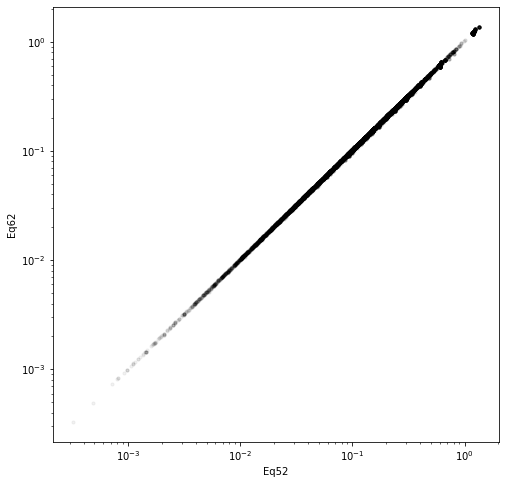

In [983]:
plt.figure(figsize=(8,8))
for col in kappa_gca_v1.columns.tolist()[2:]:
    plt.scatter(kappa_gca_v1[col], kappa_gca_v2[col], c='black', alpha=0.05, s=10)
plt.xlabel('Eq52')
plt.ylabel('Eq62')
plt.yscale('log')
plt.xscale('log')

In [984]:
# Comparing kappa-tilde and kappa-undertilde
display(kappa_gca_v2[kappa_gca_v2['alpha']=='ALL_TU_H'].head(5))
display(kappa_gca_v1[kappa_gca_v1['alpha']=='ALL_TU_H'].head(5))
print('\n\n')
display(kappa_gca_v2[kappa_gca_v2['GTCBSA']==kappa_gca_v2['GTCBSA'].tolist()[2]].head(5))
display(kappa_gca_v1[kappa_gca_v1['GTCBSA']==kappa_gca_v1['GTCBSA'].tolist()[2]].head(5))



alpha  GTCBSA  Female_&_23<=Age<60  Male_&_23<=Age<60  \
3842  ALL_TU_H   10420             0.194682           0.152387   
3843  ALL_TU_H   10580             0.099454           0.197932   
3844  ALL_TU_H   10740             0.375646           0.146291   
3845  ALL_TU_H   10900             0.394909           0.144187   
3846  ALL_TU_H   11100             0.320864           0.203183   

      Female_&_Age<23  Male_&_Age<23  Female_&_Age>=60  Male_&_Age>=60  \
3842         0.778098       1.214430          0.192867        0.447020   
3843         0.700289       0.000000          0.441546        0.450535   
3844         0.333471       0.000000          0.299532        0.346912   
3845         0.000000       0.303608          0.110386        0.337902   
3846              NaN       1.214430          0.253889        0.000000   

      Female_&_Black  Male_&_Black  Female_&_HS+  Male_&_HS+  \
3842        0.371305      0.448109      0.212906    0.278112   
3843        0.354951      0.398319      0.268763    0.296652   
3844        0.000000      0.298740      0.312524    0.191377   
3845        0.000000      0.000000      0.253297    0.239737   
3846             NaN      0.000000      0.316622    0.245600   

      Female_&_Hispanic  Male_&_Hispanic  Female_&_LT_HS  Male_&_LT_HS  \
3842           0.000000         0.000000        0.647425      0.000000   
3843           0.000000         1.229583        0.647425      0.000000   
3844           0.540832         0.204931        0.776911      0.403928   
3845           0.341646         0.151973        0.000000      0.000000   
3846           0.341646         0.614792        0.000000           NaN   

      Female_&_White&Other  Male_&_White&Other  
3842              0.219096            0.218769  
3843              0.305152            0.216222  
3844              0.233703            0.185433  
3845              0.244183            0.239268  
3846              0.283373            0.206036

alpha  GTCBSA  Female_&_23<=Age<60  Female_&_Age<23  \
3842  ALL_TU_H   10420             0.190949         0.800000   
3843  ALL_TU_H   10580             0.097547         0.720000   
3844  ALL_TU_H   10740             0.368443         0.342857   
3845  ALL_TU_H   10900             0.387337         0.000000   
3846  ALL_TU_H   11100             0.314711              NaN   

      Female_&_Age>=60  Female_&_Black  Female_&_HS+  Female_&_Hispanic  \
3842          0.187227        0.361144      0.209497           0.000000   
3843          0.428634        0.345238      0.264459           0.000000   
3844          0.290773        0.000000      0.307520           0.532223   
3845          0.107159        0.000000      0.249242           0.336207   
3846          0.246465             NaN      0.311552           0.336207   

      Female_&_LT_HS  Female_&_White&Other  Male_&_23<=Age<60  Male_&_Age<23  \
3842        0.623457              0.213469           0.151292       1.192308   
3843        0.623457              0.297315           0.196510       0.000000   
3844        0.748148              0.227700           0.145241       0.000000   
3845        0.000000              0.237911           0.143151       0.298077   
3846        0.000000              0.276094           0.201723       1.192308   

      Male_&_Age>=60  Male_&_Black  Male_&_HS+  Male_&_Hispanic  Male_&_LT_HS  \
3842        0.432337      0.434451    0.273921         0.000000      0.000000   
3843        0.435737      0.386179    0.292183         1.218750      0.000000   
3844        0.335517      0.289634    0.188494         0.203125      0.391111   
3845        0.326803      0.000000    0.236125         0.150634      0.000000   
3846        0.000000      0.000000    0.241900         0.609375           NaN   

      Male_&_White&Other  
3842            0.214421  
3843            0.211925  
3844            0.181747  
3845            0.234512  
3846            0.201941

alpha  GTCBSA  Female_&_23<=Age<60  Male_&_23<=Age<60  \
2    10_agg_H   10740             0.000000           0.000000   
228  11_agg_H   10740             0.062608           0.048764   
454  12_agg_H   10740             0.250430           0.097528   
680  13_agg_H   10740             0.000000           0.000000   
906  14_agg_H   10740             0.000000           0.024382   

     Female_&_Age<23  Male_&_Age<23  Female_&_Age>=60  Male_&_Age>=60  \
2           0.000000            0.0          0.000000        0.000000   
228         0.333471            0.0          0.149766        0.049559   
454         0.333471            0.0          0.264270        0.198236   
680         0.000000            0.0          0.000000        0.049559   
906         0.166735            0.0          0.035262        0.000000   

     Female_&_Black  Male_&_Black  Female_&_HS+  Male_&_HS+  \
2               0.0       0.00000      0.000000    0.000000   
228             0.0       0.00000      0.100152    0.047844   
454             0.0       0.29874      0.248398    0.127585   
680             0.0       0.00000      0.000000    0.015948   
906             0.0       0.00000      0.016031    0.015948   

     Female_&_Hispanic  Male_&_Hispanic  Female_&_LT_HS  Male_&_LT_HS  \
2             0.000000         0.000000         0.00000           0.0   
228           0.265724         0.068310         0.51794           0.0   
454           0.426951         0.170775         0.51794           0.0   
680           0.000000         0.000000         0.00000           0.0   
906           0.075921         0.000000         0.25897           0.0   

     Female_&_White&Other  Male_&_White&Other  
2                0.000000            0.000000  
228              0.035342            0.030905  
454              0.177028            0.061811  
680              0.000000            0.030905  
906              0.000000            0.030905

alpha  GTCBSA  Female_&_23<=Age<60  Female_&_Age<23  Female_&_Age>=60  \
2    10_agg_H   10740             0.000000         0.000000          0.000000   
228  11_agg_H   10740             0.061407         0.342857          0.145387   
454  12_agg_H   10740             0.245628         0.342857          0.256542   
680  13_agg_H   10740             0.000000         0.000000          0.000000   
906  14_agg_H   10740             0.000000         0.171429          0.034231   

     Female_&_Black  Female_&_HS+  Female_&_Hispanic  Female_&_LT_HS  \
2               0.0      0.000000           0.000000        0.000000   
228             0.0      0.098548           0.261494        0.498765   
454             0.0      0.244421           0.420154        0.498765   
680             0.0      0.000000           0.000000        0.000000   
906             0.0      0.015775           0.074713        0.249383   

     Female_&_White&Other  Male_&_23<=Age<60  Male_&_Age<23  Male_&_Age>=60  \
2                0.000000           0.000000            0.0        0.000000   
228              0.034434           0.048414            0.0        0.047931   
454              0.172481           0.096827            0.0        0.191724   
680              0.000000           0.000000            0.0        0.047931   
906              0.000000           0.024207            0.0        0.000000   

     Male_&_Black  Male_&_HS+  Male_&_Hispanic  Male_&_LT_HS  \
2        0.000000    0.000000         0.000000           0.0   
228      0.000000    0.047123         0.067708           0.0   
454      0.289634    0.125662         0.169271           0.0   
680      0.000000    0.015708         0.000000           0.0   
906      0.000000    0.015708         0.000000           0.0   

     Male_&_White&Other  
2              0.000000  
228            0.030291  
454            0.060582  
680            0.030291  
906            0.030291

### EXPORTS

In [985]:
kappa_gca_v2.to_csv('kappa_gca_eq_62.csv', index=False)
kappa_gca_v1.to_csv('kappa_gca_eq_52.csv', index=False)

df_tus_trunc_bin['pop_bin'] = df_tus_trunc_bin['pop_bin'].astype(str)
df_pew_trunc_p_bins['pop_bin'] = df_pew_trunc_p_bins['pop_bin'].astype(str)
df_tus_trunc_bin.to_csv('df_tus_trunc_bin.csv', index=False)
df_pew_trunc_p_bins.to_csv('df_pew_trunc_p_bins.csv', index=False)

### TODO

### Equation 62 (Model 3)
$$\utilde{\kappa}(g,\mathbf{c},\alpha)=\frac{u(g,\mathbf{c},\alpha)}{\langle\phi(\mathbf{c}|p(g))\rangle}=\frac{\sum_{i\in g}a(i|\alpha)\delta_{\mathbf{c},\mathbf{c}(i)}}{s(g,\mathbf{c})\langle\phi(\mathbf{c}|p(g))\rangle}$$

### Equation 52 (Model 3)
$$\tilde{\kappa}(g,\mathbf{c},\alpha)=\frac{u(g,\mathbf{c},\alpha)}{\langle\phi(\mathbf{c})\rangle}=\frac{\sum_{i\in g}a(i|\alpha)\delta_{\mathbf{c},\mathbf{c}(i)}}{s(g,\mathbf{c})\langle\phi(\mathbf{c})\rangle}$$

### Equation 64 (Model 2)
$$\kappa(g,\alpha)=\frac{\sum_{\mathbf{c}}\kappa(g,\mathbf{c},\alpha)p(g,\mathbf{c})}{p(g)}=\frac{\sum_{\mathbf{c}}\kappa(g,\mathbf{c},\alpha)p(g,\mathbf{c})}{\sum_{\mathbf{c}}p(g,\mathbf{c})}$$


$\langle \phi \rangle = $ average $\phi(g)$   
$\phi(g)$ = average $\phi$ for a given $g$  
$\phi(c)$ = average $\phi$ for each characteristic  
$\phi(g,c)$ = average $\phi$ for each characteristic in each city  
$\tilde\phi(g,c,a)$ = $\phi$ model for each activity, city, and characteristic  

    - Avg all phi: kappa(alpha) (relates to activity but c is averaged out)
    - f(g|alpha)/phi(g) = kappa(g | alpha)
    - phi_tilde model = kappa(g, c, alpha) (there might be a population related correction possible if this goes haywire)

DO MODEL 3 first  
model 1 is Eq 45; homegeneity assumption model  
p(x) is actual people meeting the condition  
eq 55 has phi_tilde (g,c)   
measures to do:
 - model 2 (footnote) is eq 63; the right hand side of this might be a good test agains the left hand side directly
 - model 2 (correct): average $\kappa$ - 4.2, eq 64 (k(c,g,a) is 62 and 52)
 - model 3 (eq 62 and 52)
phi(g) vs. under-tilde phi(g) is a good test to do; do this one if possible

## The list:
 - generate kappas with 2D c variables: female + education, male + education, etc
 - phi(g) vs. under-tilde phi(g) (UNCHITTA)
 - finish k(g,a) eq 64
 - Does propensity have a relationship with population? PLOT THIS -> K(g,alpha) (across all alphas)
 - generate the stylized boxplots by g and alpha across kappas & g
 - finalize plasma plot

## New Item to do immediately:
 - the ∆f versus ∆(kappa/phi), and also the table of kappa(alpha). These are all good results

## Notes on additional work required:
 - update 62 and 52 to use c = {some pair of c's w/ sex as one element}

## EQ-64: $\kappa(g,\alpha)$

In [1020]:
ps = []

dual_class_df = c_phis_p_df[['class1_type','class2_type','class1','class2']]
dual_class_df = dual_class_df.drop_duplicates()

for idx, row in dual_class_df.iterrows():
    c1  = row['class1']
    c2  = row['class2']
    tdf = df_tus_trunc_bin[df_tus_trunc_bin[row['class1_type']]==row['class1']]
    tdf = tdf[tdf[row['class2_type']]==row['class2']]
    tdf = tdf[['GTCBSA','TUCASEID']]
    tdf = tdf.groupby('GTCBSA').count()
    tdf.columns = [c2+'_&_'+c1]
    ps.append(tdf)

p_df = pd.concat(ps,axis=1)
p_df = p_df.reset_index()
p_df['p'] = p_df[p_df.columns.tolist()[1:]].sum(axis=1)
p_df

GTCBSA  Female_&_23<=Age<60  Female_&_Age>=60  Female_&_Age<23  \
0     10420                   28                23              3.0   
1     10580                   29                23              5.0   
2     10740                   41                36              7.0   
3     10900                   26                23              3.0   
4     11100                    8                 5              NaN   
..      ...                  ...               ...              ...   
221   49180                   24                24              2.0   
222   49340                   44                22              5.0   
223   49620                   18                13              5.0   
224   49660                   21                17              2.0   
225   49740                   11                14              1.0   

     Male_&_23<=Age<60  Male_&_Age>=60  Male_&_Age<23  Female_&_White&Other  \
0                   24             9.0            1.0                  48.0   
1                   20            11.0            3.0                  47.0   
2                   50            25.0            5.0                  45.0   
3                   19            11.0            4.0                  47.0   
4                   12             2.0            1.0                   9.0   
..                 ...             ...            ...                   ...   
221                 14            18.0            2.0                  31.0   
222                 40            19.0            4.0                  63.0   
223                  9             6.0            5.0                  32.0   
224                 15            17.0            3.0                  37.0   
225                  7             3.0            1.0                   6.0   

     Female_&_Black  Female_&_Hispanic  Male_&_White&Other  Male_&_Black  \
0               5.0                1.0                24.0           8.0   
1               7.0                3.0                30.0           3.0   
2               3.0               36.0                40.0           4.0   
3               1.0                4.0                31.0           1.0   
4               NaN                4.0                12.0           1.0   
..              ...                ...                 ...           ...   
221            14.0                5.0                27.0           4.0   
222             2.0                6.0                54.0           6.0   
223             1.0                3.0                18.0           1.0   
224             3.0                NaN                25.0           8.0   
225             NaN               20.0                 3.0           NaN   

     Male_&_Hispanic  Female_&_HS+  Female_&_LT_HS  Male_&_HS+  Male_&_LT_HS  \
0                2.0            52             2.0          32           2.0   
1                1.0            53             4.0          30           4.0   
2               36.0            79             5.0          77           3.0   
3                2.0            50             2.0          32           2.0   
4                2.0            12             1.0          15           NaN   
..               ...           ...             ...         ...           ...   
221              3.0            43             7.0          28           6.0   
222              3.0            67             4.0          57           6.0   
223              1.0            32             4.0          16           4.0   
224              2.0            37             3.0          29           6.0   
225              8.0            11            15.0           6           5.0   

         p  
0    264.0  
1    273.0  
2    492.0  
3    258.0  
4     84.0  
..     ...  
221  252.0  
222  402.0  
223  168.0  
224  225.0  
225  111.0  

[226 rows x 18 columns]

In [1005]:
kappa_gca_v1

alpha  GTCBSA  Female_&_23<=Age<60  Female_&_Age<23  \
0        10_agg_H   10420             0.000000         0.000000   
1        10_agg_H   10580             0.000000         0.000000   
2        10_agg_H   10740             0.000000         0.000000   
3        10_agg_H   10900             0.000000         0.000000   
4        10_agg_H   11100             0.000000              NaN   
...           ...     ...                  ...              ...   
4515  SOCIAL_TU_H   49180             0.472067         0.600000   
4516  SOCIAL_TU_H   49340             0.235953         0.000000   
4517  SOCIAL_TU_H   49620             0.489551         0.059327   
4518  SOCIAL_TU_H   49660             0.434433         0.000000   
4519  SOCIAL_TU_H   49740             0.486051         0.000000   

      Female_&_Age>=60  Female_&_Black  Female_&_HS+  Female_&_Hispanic  \
0             0.000000        0.000000      0.000000           0.000000   
1             0.000000        0.000000      0.000000           0.000000   
2             0.000000        0.000000      0.000000           0.000000   
3             0.000000        0.000000      0.000000           0.000000   
4             0.000000             NaN      0.000000           0.000000   
...                ...             ...           ...                ...   
4515          0.423467        0.258929      0.412906           0.268966   
4516          0.181891        0.000000      0.213797           0.448276   
4517          0.402609        1.208333      0.438011           0.000000   
4518          0.253307        0.502342      0.361790                NaN   
4519          0.285828             NaN      0.395885           0.352829   

      Female_&_LT_HS  Female_&_White&Other  Male_&_23<=Age<60  Male_&_Age<23  \
0           0.000000              0.000000           0.000000       0.000000   
1           0.000000              0.000000           0.000000       0.000000   
2           0.000000              0.000000           0.000000       0.000000   
3           0.000000              0.000000           0.000000       0.000000   
4           0.000000              0.000000           0.000000       0.000000   
...              ...                   ...                ...            ...   
4515        0.712522              0.571002           0.086453       0.147366   
4516        0.000000              0.187239           0.128514       0.298077   
4517        0.077058              0.407453           0.134482       0.000000   
4518        0.000000              0.318812           0.403446       0.495680   
4519        0.332510              0.465328           0.000000       1.192308   

      Male_&_Age>=60  Male_&_Black  Male_&_HS+  Male_&_Hispanic  Male_&_LT_HS  \
0           0.000000      0.000000    0.000000         0.000000      0.000000   
1           0.000000      0.000000    0.000000         0.000000      0.000000   
2           0.000000      0.000000    0.000000         0.000000      0.000000   
3           0.000000      0.000000    0.000000         0.000000      0.000000   
4           0.000000      0.000000    0.000000         0.000000           NaN   
...              ...           ...         ...              ...           ...   
4515        0.199713      0.000000    0.129589         0.406250      0.243896   
4516        0.267858      0.000000    0.180245         0.406250      0.195556   
4517        0.000000      0.000000    0.075594         0.000000      0.000000   
4518        0.158398      0.289634    0.302258         0.000000      0.243896   
4519        0.399425           NaN    0.000000         0.152344      0.469333   

      Male_&_White&Other  
0               0.000000  
1               0.000000  
2               0.000000  
3               0.000000  
4               0.000000  
...                  ...  
4515            0.145721  
4516            0.190596  
4517            0.067314  
4518            0.314756  
4519            0.403883  

[4520 rows x 18 columns]

In [1062]:
alphas = kappa_gca_v1.alpha.unique().tolist()
cbsas = kappa_gca_v1.GTCBSA.unique().tolist()
characteristics = kappa_gca_v1.columns.tolist()[2:]
kga_dict = {'GTCBSA':cbsas}
for alpha in alphas:
    temp_list = []
    for cbsa in cbsas:
        p_row = p_df[p_df.GTCBSA==cbsa]
        k_row = kappa_gca_v1[kappa_gca_v1.GTCBSA==cbsa]
        k_row = k_row[k_row.alpha==alpha]
        c_p = [k_row[i].tolist()[0]*p_row[i].tolist()[0] for i in characteristics]
        c_p = sum([i for i in c_p if i>0])
        p_tot = p_row.p.tolist()[0]
        kga = c_p / p_tot
        temp_list.append(kga)
    kga_dict[alpha] = temp_list

kga_1_df = pd.DataFrame(kga_dict)
kga_1_df = df_cbsa.merge(kga_1_df, how='right', on='GTCBSA')
kga_1_df

GTCBSA  10_agg_H  11_agg_H  12_agg_H  13_agg_H  14_agg_H  15_agg_H  \
0     10420       0.0  0.121547  0.166513  0.013972  0.000000  0.000000   
1     10580       0.0  0.067759  0.196222  0.027144  0.013630  0.013108   
2     10740       0.0  0.085957  0.193867  0.007357  0.022859  0.007381   
3     10900       0.0  0.129634  0.147486  0.014525  0.000000  0.000000   
4     11100       0.0  0.133231  0.177844  0.000000  0.000000  0.000000   
..      ...       ...       ...       ...       ...       ...       ...   
221   49180       0.0  0.168489  0.250468  0.045019  0.029531  0.014411   
222   49340       0.0  0.137663  0.144655  0.011267  0.018578  0.000000   
223   49620       0.0  0.161258  0.232759  0.022306  0.000000  0.000000   
224   49660       0.0  0.170591  0.281769  0.000000  0.016140  0.015663   
225   49740       0.0  0.209045  0.278706  0.032292  0.000000  0.000000   

     16_agg_H  18_agg_H   1_agg_H  ...   3_agg_H   4_agg_H   5_agg_H  \
0    0.000000  0.083886  0.003452  ...  0.027953  0.006904  0.000000   
1    0.000000  0.121957  0.000000  ...  0.000000  0.054032  0.013328   
2    0.000000  0.068141  0.000000  ...  0.007825  0.083788  0.007617   
3    0.000000  0.100528  0.000000  ...  0.014525  0.071557  0.000000   
4    0.000000  0.174179  0.000000  ...  0.043232  0.043102  0.043102   
..        ...       ...       ...  ...       ...       ...       ...   
221  0.014640  0.132579  0.000000  ...  0.029742  0.168106  0.000000   
222  0.009034  0.100727  0.000000  ...  0.009034  0.091615  0.000000   
223  0.000000  0.176315  0.000000  ...  0.022306  0.093578  0.000000   
224  0.032318  0.113862  0.016086  ...  0.049038  0.097620  0.000000   
225  0.000000  0.135188  0.000000  ...  0.000000  0.041067  0.000000   

      6_agg_H   7_agg_H   8_agg_H   9_agg_H  ALL_TU_H  CARE_TU_H  SOCIAL_TU_H  
0    0.000000  0.069792  0.014095  0.013972  0.236164   0.006904     0.194363  
1    0.000000  0.067890  0.000000  0.000000  0.276234   0.054032     0.209852  
2    0.007705  0.007705  0.000000  0.015128  0.269296   0.083788     0.201224  
3    0.000000  0.043523  0.014422  0.000000  0.233172   0.071557     0.176040  
4    0.000000  0.000000  0.000000  0.000000  0.264308   0.043102     0.177844  
..        ...       ...       ...       ...       ...        ...          ...  
221  0.000000  0.058918  0.000000  0.000000  0.392612   0.168106     0.331156  
222  0.000000  0.036380  0.000000  0.000000  0.229134   0.091615     0.192970  
223  0.000000  0.111374  0.000000  0.000000  0.364348   0.093578     0.277056  
224  0.000000  0.015663  0.000000  0.000000  0.346604   0.097620     0.314511  
225  0.034684  0.065814  0.000000  0.000000  0.354462   0.041067     0.321682  

[226 rows x 21 columns]

In [1063]:
alphas = kappa_gca_v2.alpha.unique().tolist()
cbsas = kappa_gca_v2.GTCBSA.unique().tolist()
characteristics = kappa_gca_v2.columns.tolist()[2:]
kga_dict = {'GTCBSA':cbsas}
for alpha in alphas:
    temp_list = []
    for cbsa in cbsas:
        p_row = p_df[p_df.GTCBSA==cbsa]
        k_row = kappa_gca_v2[kappa_gca_v2.GTCBSA==cbsa]
        k_row = k_row[k_row.alpha==alpha]
        c_p = [k_row[i].tolist()[0]*p_row[i].tolist()[0] for i in characteristics]
        c_p = sum([i for i in c_p if i > 0])
        p_tot = p_row.p.tolist()[0]
        kga = c_p / p_tot
        temp_list.append(kga)
    kga_dict[alpha] = temp_list

kga_2_df = pd.DataFrame(kga_dict)
kga_2_df = df_cbsa.merge(kga_2_df, how='right', on='GTCBSA')
kga_2_df

GTCBSA  10_agg_H  11_agg_H  12_agg_H  13_agg_H  14_agg_H  15_agg_H  \
0     10420       0.0  0.123602  0.169581  0.014049  0.000000  0.000000   
1     10580       0.0  0.069186  0.200495  0.027649  0.013960  0.013341   
2     10740       0.0  0.087414  0.197433  0.007527  0.023200  0.007486   
3     10900       0.0  0.132371  0.150534  0.014826  0.000000  0.000000   
4     11100       0.0  0.135710  0.181247  0.000000  0.000000  0.000000   
..      ...       ...       ...       ...       ...       ...       ...   
221   49180       0.0  0.172206  0.256206  0.045900  0.030247  0.014616   
222   49340       0.0  0.140512  0.147600  0.011427  0.018996  0.000000   
223   49620       0.0  0.164712  0.237586  0.022769  0.000000  0.000000   
224   49660       0.0  0.173992  0.287525  0.000000  0.016370  0.016094   
225   49740       0.0  0.214260  0.285318  0.032935  0.000000  0.000000   

     16_agg_H  18_agg_H   1_agg_H  ...   3_agg_H   4_agg_H   5_agg_H  \
0    0.000000  0.085268  0.003538  ...  0.028548  0.007076  0.000000   
1    0.000000  0.124442  0.000000  ...  0.000000  0.055174  0.013468   
2    0.000000  0.069346  0.000000  ...  0.007960  0.085438  0.007775   
3    0.000000  0.102587  0.000000  ...  0.014826  0.072895  0.000000   
4    0.000000  0.176950  0.000000  ...  0.043849  0.043714  0.043714   
..        ...       ...       ...  ...       ...       ...       ...   
221  0.014830  0.135623  0.000000  ...  0.030358  0.171919  0.000000   
222  0.009162  0.102789  0.000000  ...  0.009162  0.093519  0.000000   
223  0.000000  0.180175  0.000000  ...  0.022769  0.095677  0.000000   
224  0.033095  0.116079  0.016459  ...  0.049708  0.099741  0.000000   
225  0.000000  0.138093  0.000000  ...  0.000000  0.041611  0.000000   

      6_agg_H   7_agg_H   8_agg_H   9_agg_H  ALL_TU_H  CARE_TU_H  SOCIAL_TU_H  
0    0.000000  0.070832  0.014436  0.014049  0.240872   0.007076     0.197969  
1    0.000000  0.069190  0.000000  0.000000  0.281785   0.055174     0.214455  
2    0.007724  0.007724  0.000000  0.015459  0.274399   0.085438     0.204960  
3    0.000000  0.044283  0.014772  0.000000  0.237900   0.072895     0.179714  
4    0.000000  0.000000  0.000000  0.000000  0.268945   0.043714     0.181247  
..        ...       ...       ...       ...       ...        ...          ...  
221  0.000000  0.060098  0.000000  0.000000  0.401406   0.171919     0.338681  
222  0.000000  0.037085  0.000000  0.000000  0.233599   0.093519     0.196847  
223  0.000000  0.113759  0.000000  0.000000  0.372253   0.095677     0.282956  
224  0.000000  0.016094  0.000000  0.000000  0.353597   0.099741     0.320985  
225  0.035284  0.067269  0.000000  0.000000  0.362468   0.041611     0.329345  

[226 rows x 21 columns]

0 10_agg_H 0 0
1 11_agg_H 1 0
2 12_agg_H 2 0
3 13_agg_H 3 0
4 14_agg_H 0 1
5 15_agg_H 1 1
6 16_agg_H 2 1
7 18_agg_H 3 1
8 1_agg_H 0 2
9 2_agg_H 1 2
10 3_agg_H 2 2
11 4_agg_H 3 2
12 5_agg_H 0 3
13 6_agg_H 1 3
14 7_agg_H 2 3
15 8_agg_H 3 3
16 9_agg_H 0 4
17 ALL_TU_H 1 4
18 CARE_TU_H 2 4
19 SOCIAL_TU_H 3 4


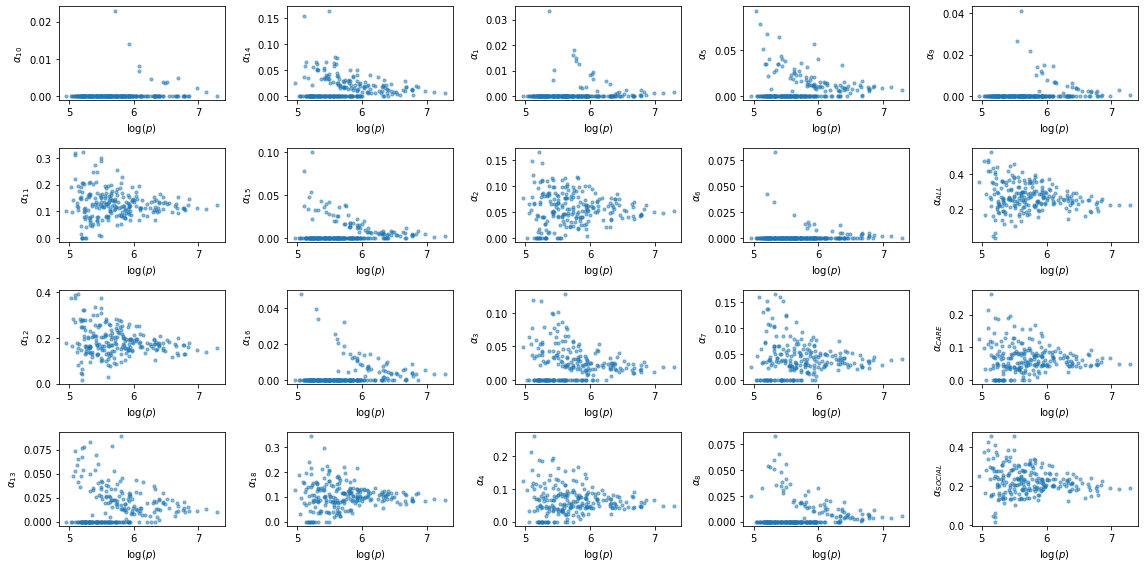

In [1137]:
cols = ['10_agg_H', '11_agg_H','12_agg_H', '13_agg_H', '14_agg_H', '15_agg_H', 
        '16_agg_H', '18_agg_H','1_agg_H', '2_agg_H', '3_agg_H', '4_agg_H', 
        '5_agg_H', '6_agg_H','7_agg_H', '8_agg_H', '9_agg_H', 'ALL_TU_H', 
        'CARE_TU_H','SOCIAL_TU_H']

col_label = ['\\alpha_{'+i.split('_')[0]+'}' for i in cols]

fig, axes = plt.subplots(4,5, figsize=(16,8))
for idx, col in enumerate(cols):
    print(idx, col, idx%4, idx//4)
    x = idx%4
    y = idx//4
    axes[x,y].scatter(kga_1_df['LOG_POP'], kga_1_df[col],s=10, alpha=0.5)
    axes[x,y].set_ylabel(f'${col_label[idx]}$')
    axes[x,y].set_xlabel(f'$\log(p)$')

plt.tight_layout()

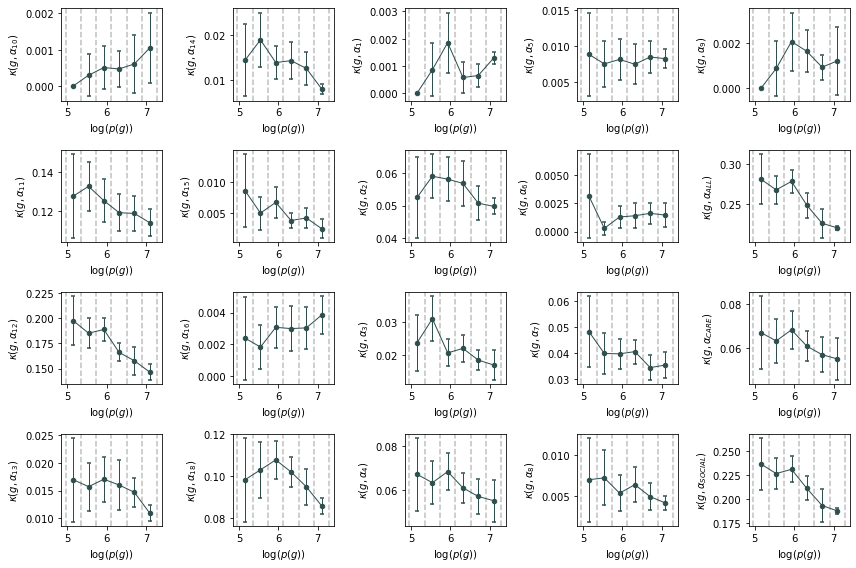

In [1128]:
cols = sorted(['10_agg_H', '11_agg_H','12_agg_H', '13_agg_H', '14_agg_H', '15_agg_H', 
        '16_agg_H', '18_agg_H','1_agg_H', '2_agg_H', '3_agg_H', '4_agg_H', 
        '5_agg_H', '6_agg_H','7_agg_H', '8_agg_H', '9_agg_H', 'ALL_TU_H', 
        'CARE_TU_H','SOCIAL_TU_H'])

col_label = ['\\alpha_{'+i.split('_')[0]+'}' for i in cols]

fig, axes = plt.subplots(4,5, figsize=(12,8))
for idx, col in enumerate(cols):
    tdf = kga_1_df[kga_1_df[col]>0]
    #print(idx, col, idx%4, idx//4)
    x = idx%4
    y = idx//4
    axes[x,y] = binplot_dim(axes[x,y], kga_1_df['LOG_POP'], kga_1_df[col], 6, c='darkslategrey', l=1.5, label='$\kappa(g,\\alpha)$', s=20)
    axes[x,y].set_ylabel(f'$\kappa(g,{col_label[idx]})$')
    axes[x,y].set_xlabel(f'$\log(p(g))$')

plt.tight_layout()

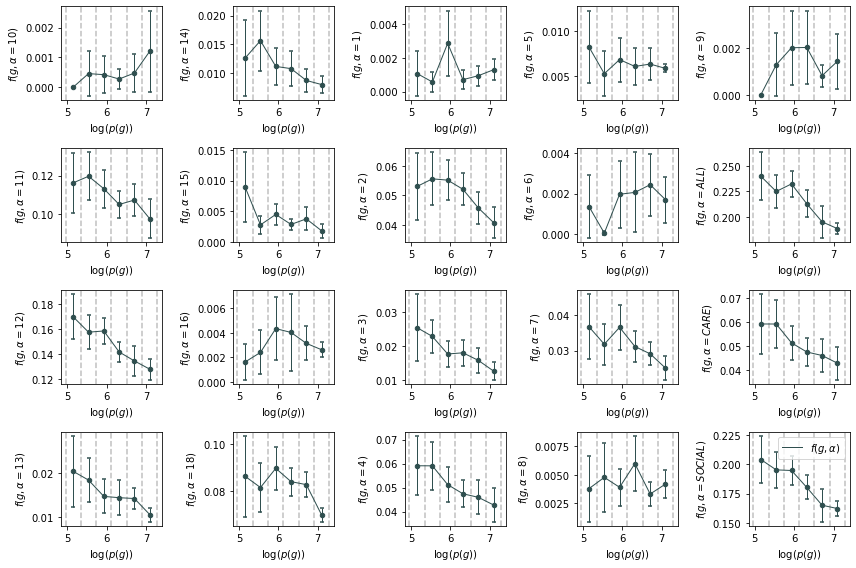

In [1132]:
cbsa_weights = df_cbsa[['GTCBSA', 'LOG_POP']]
f_df = cbsa_weights.merge(df_fg, on='GTCBSA', how='left')
fcols = sorted([i for i in f_df.columns.tolist() if 'all' in i])
flabels = [i.split('_')[2] for i in fcols]

fig, axes = plt.subplots(4,5, figsize=(12,8))
for idx, col in enumerate(fcols):
    tdf = f_df[f_df[col]>0]
    #print(idx, col, idx%4, idx//4)
    x = idx%4
    y = idx//4
    axes[x,y] = binplot_dim(axes[x,y], f_df['LOG_POP'], f_df[col], 6, c='darkslategrey', l=1.5, label='$f(g,\\alpha)$', s=20)
    axes[x,y].set_ylabel(f'$f(g, \\alpha={flabels[idx]})$')
    axes[x,y].set_xlabel(f'$\log(p(g))$')

plt.legend()
plt.tight_layout()

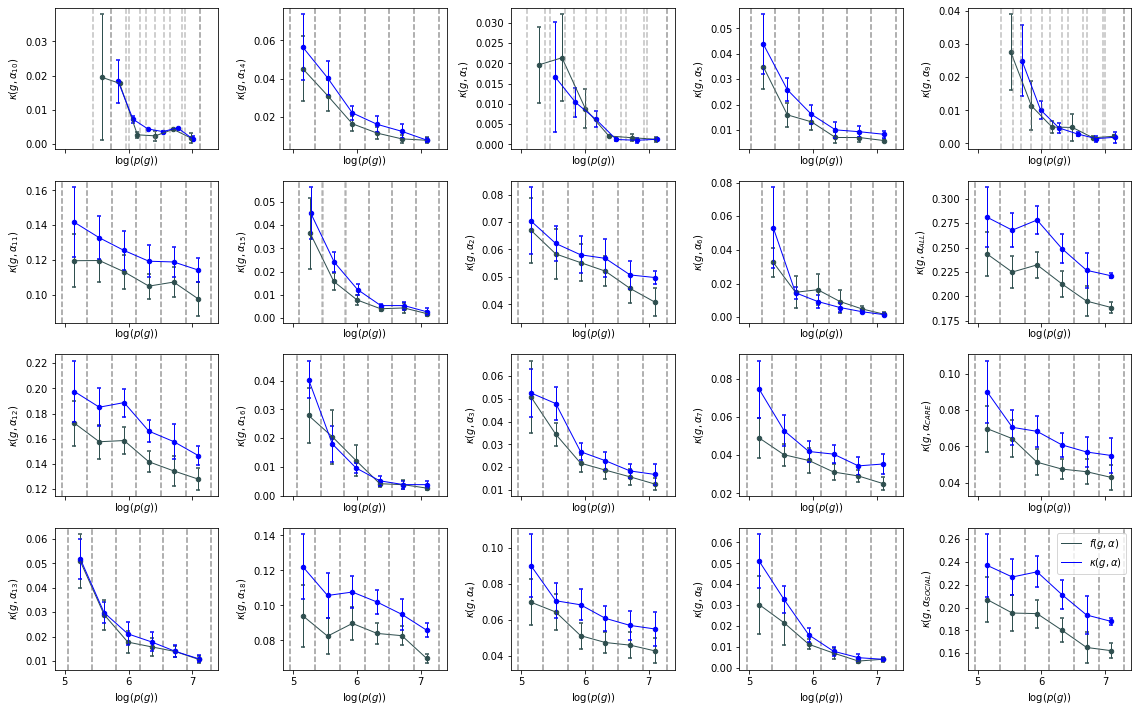

In [1139]:
cbsa_weights = df_cbsa[['GTCBSA', 'LOG_POP']]
f_df = cbsa_weights.merge(df_fg, on='GTCBSA', how='left')
fcols = sorted([i for i in f_df.columns.tolist() if 'all' in i])
flabels = [i.split('_')[2] for i in fcols]

fig, axes = plt.subplots(4,5, figsize=(16,10), sharex=True)
for idx, col in enumerate(fcols):
    tdf = f_df[f_df[col]>0]
    #print(idx, col, idx%4, idx//4)
    x = idx%4
    y = idx//4
    axes[x,y] = binplot_dim(axes[x,y], tdf['LOG_POP'], tdf[col], 6, c='darkslategrey', l=1.5, label='$f(g,\\alpha)$', s=20)
    axes[x,y].set_ylabel(f'$f(g, \\alpha={flabels[idx]})$')
    axes[x,y].set_xlabel(f'$\log(p(g))$')

for idx, col in enumerate(cols):
    tdf = kga_1_df[kga_1_df[col]>0]
    #print(idx, col, idx%4, idx//4)
    x = idx%4
    y = idx//4
    axes[x,y] = binplot_dim(axes[x,y], tdf['LOG_POP'], tdf[col], 6, c='blue', l=1.5, label='$\kappa(g,\\alpha)$', s=20)
    axes[x,y].set_ylabel(f'$\kappa(g,{col_label[idx]})$')
    axes[x,y].set_xlabel(f'$\log(p(g))$')

plt.legend()
plt.tight_layout()


# EQ-65: $\kappa(\alpha)$

In [1176]:
kg_1_df = p_df[['GTCBSA','p']].merge(kga_1_df, how='inner', on='GTCBSA')
kg_1_df['bin'] = pd.cut(kg_1_df['LOG_POP'] , 6)
kg_1_df['bin_str'] = kg_1_df['bin'].apply(lambda x: str(x.left)+'_'+str(x.right))

alphas = ['10_agg_H', '11_agg_H','12_agg_H', '13_agg_H', '14_agg_H', '15_agg_H', \
                '16_agg_H', '18_agg_H','1_agg_H', '2_agg_H', '3_agg_H', '4_agg_H', \
                '5_agg_H', '6_agg_H','7_agg_H', '8_agg_H', '9_agg_H', 'ALL_TU_H', \
                'CARE_TU_H', 'SOCIAL_TU_H']

dfs = []
for a in alphas:
    kg_1_df[a+'*p'] = kg_1_df[a] * kg_1_df['p']
    tdf = kg_1_df[['p','bin_str', a+'*p']]
    tdf = tdf.groupby('bin_str').sum()
    tdf[f'kappa_{a}'] = tdf[a+'*p'] / tdf['p']
    tdf = tdf[[f'kappa_{a}']]
    dfs.append(tdf)

kg_df = pd.concat(dfs, axis=1)
kg_df


kappa_10_agg_H  kappa_11_agg_H  kappa_12_agg_H  kappa_13_agg_H  \
bin_str                                                                       
4.958_5.348        0.000000        0.125992        0.192390        0.015020   
5.348_5.737        0.000357        0.132705        0.186025        0.016345   
5.737_6.125        0.000602        0.127114        0.189703        0.016243   
6.125_6.513        0.000556        0.121507        0.166557        0.016443   
6.513_6.902        0.000444        0.118134        0.155954        0.014211   
6.902_7.29         0.000841        0.115669        0.147851        0.010681   

             kappa_14_agg_H  kappa_15_agg_H  kappa_16_agg_H  kappa_18_agg_H  \
bin_str                                                                       
4.958_5.348        0.014123        0.008246        0.002494        0.095720   
5.348_5.737        0.019654        0.004606        0.002576        0.103152   
5.737_6.125        0.014493        0.006314        0.003666        0.107072   
6.125_6.513        0.013530        0.003949        0.003006        0.101898   
6.513_6.902        0.012447        0.004257        0.002962        0.094100   
6.902_7.29         0.007756        0.002531        0.003675        0.085927   

             kappa_1_agg_H  kappa_2_agg_H  kappa_3_agg_H  kappa_4_agg_H  \
bin_str                                                                   
4.958_5.348       0.000000       0.054620       0.024027       0.066316   
5.348_5.737       0.000881       0.059179       0.030337       0.062382   
5.737_6.125       0.001879       0.059639       0.021326       0.067960   
6.125_6.513       0.000561       0.057678       0.022025       0.059683   
6.513_6.902       0.000654       0.050214       0.018130       0.056506   
6.902_7.29        0.001329       0.050286       0.017395       0.053740   

             kappa_5_agg_H  kappa_6_agg_H  kappa_7_agg_H  kappa_8_agg_H  \
bin_str                                                                   
4.958_5.348       0.007630       0.002517       0.045457       0.005746   
5.348_5.737       0.007190       0.000357       0.038348       0.006391   
5.737_6.125       0.008566       0.001222       0.039125       0.005965   
6.125_6.513       0.007566       0.001490       0.040214       0.006279   
6.513_6.902       0.008487       0.001739       0.034213       0.005216   
6.902_7.29        0.007993       0.001200       0.036220       0.004306   

             kappa_9_agg_H  kappa_ALL_TU_H  kappa_CARE_TU_H  kappa_SOCIAL_TU_H  
bin_str                                                                         
4.958_5.348       0.000000        0.276683         0.066316           0.232748  
5.348_5.737       0.001072        0.269549         0.062382           0.228195  
5.737_6.125       0.002287        0.279065         0.067960           0.232137  
6.125_6.513       0.001733        0.248736         0.059683           0.211668  
6.513_6.902       0.000947        0.224522         0.056506           0.191356  
6.902_7.29        0.001111        0.220589         0.053740           0.188464

In [1199]:
kg_df.columns

Index(['kappa_10_agg_H', 'kappa_11_agg_H', 'kappa_12_agg_H', 'kappa_13_agg_H',
       'kappa_14_agg_H', 'kappa_15_agg_H', 'kappa_16_agg_H', 'kappa_18_agg_H',
       'kappa_1_agg_H', 'kappa_2_agg_H', 'kappa_3_agg_H', 'kappa_4_agg_H',
       'kappa_5_agg_H', 'kappa_6_agg_H', 'kappa_7_agg_H', 'kappa_8_agg_H',
       'kappa_9_agg_H', 'kappa_ALL_TU_H', 'kappa_CARE_TU_H',
       'kappa_SOCIAL_TU_H'],
      dtype='object')

In [1203]:
print(xv)

['4.958_5.348', '5.348_5.737', '5.737_6.125', '6.125_6.513', '6.513_6.902', '6.902_7.29']


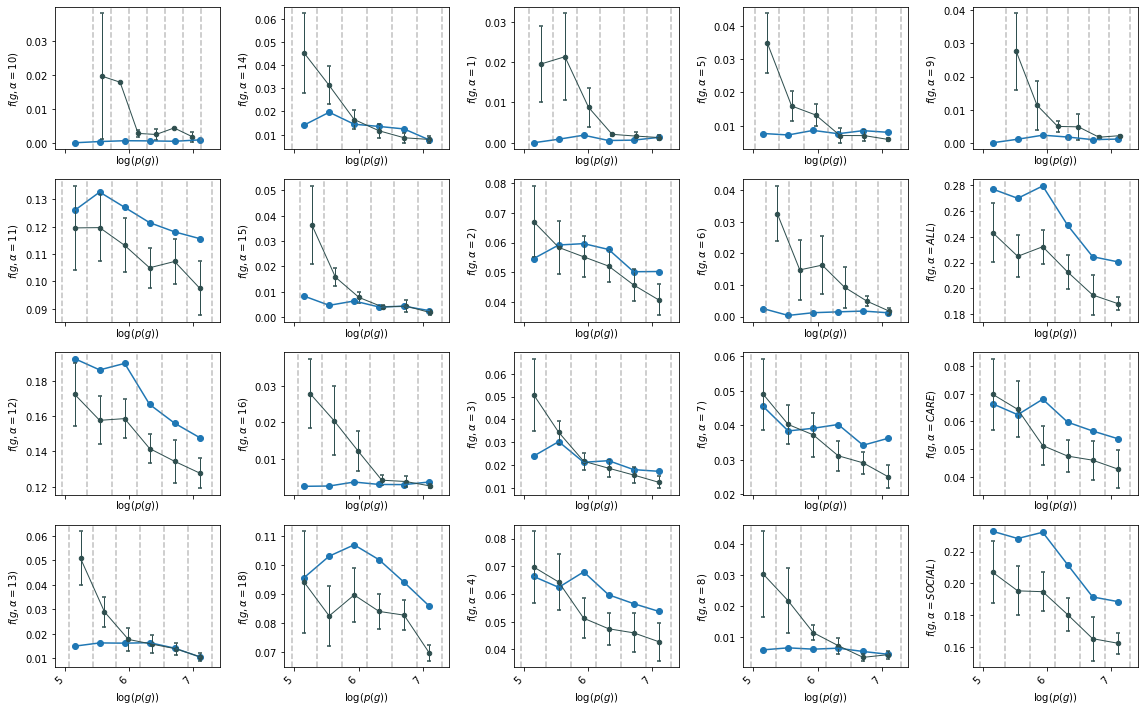

In [1207]:
kg_cols = kg_df.columns.tolist()
xv = kg_df.index.tolist()
xv = [i.split('_') for i in xv]
xv = [(float(i[0])+float(i[1]))/2 for i in xv]


fig, axes = plt.subplots(4,5, figsize=(16,10), sharex=True)
fig.autofmt_xdate(rotation=45)
#plt.xticks(rotation=45, ha='right')
for idx, col in enumerate(kg_cols):

    #print(idx, col, idx%4, idx//4)
    x = idx%4
    y = idx//4
    axes[x,y].scatter(xv, kg_df[col])
    axes[x,y].plot(xv, kg_df[col])
    a = col.split('_')[1]
    axes[x,y].set_ylabel(f'$\kappa(g,\\alpha={a})$')
    axes[x,y].set_xlabel(f'$\log(g)$')


for idx, col in enumerate(fcols):
    tdf = f_df[f_df[col]>0]
    #print(idx, col, idx%4, idx//4)
    x = idx%4
    y = idx//4
    axes[x,y] = binplot_dim(axes[x,y], tdf['LOG_POP'], tdf[col], 6, c='darkslategrey', l=1.5, label='$f(g,\\alpha)$', s=20)
    axes[x,y].set_ylabel(f'$f(g, \\alpha={flabels[idx]})$')
    axes[x,y].set_xlabel(f'$\log(p(g))$')

plt.tight_layout()

### A new take on $\phi$ using # of family members

In [1302]:
n_bins = 6

f_min = {'None':0, '1 up to 5':1, 'More than 20':21, '6 up to 10':6, '11 up to 20':11}
f_max = {'None':0, '1 up to 5':5, 'More than 20':30, '6 up to 10':10, '11 up to 20':20}
f_mean = {'None':0, '1 up to 5':3, 'More than 20':25, '6 up to 10':8, '11 up to 20':16}

# experimenting
#f_mean = {'None':0, '1 up to 5':(1**0.5+5**0.5)**2, 'More than 20':(20**0.5+30**0.5)**2, '6 up to 10':(6**0.5+10**0.5)**2, '11 up to 20':(11**0.5+20**0.5)**2}



cbsa_pop_df = copy.deepcopy(df_cbsa)
cbsa_pop_df = cbsa_pop_df[cbsa_pop_df['GTCBSA'].isin(df_tus_trunc['GTCBSA'].tolist())]
cbsa_pop_df['pop_bin'] = pd.cut(cbsa_pop_df['LOG_POP'], n_bins,)
cbsa_pop_df

cbsa_bins = copy.deepcopy(cbsa_pop_df[['GTCBSA','pop_bin']])
df_pew_trunc_p_bins = copy.deepcopy(df_pew_trunc)
df_pew_trunc_p_bins = df_pew_trunc_p_bins[~df_pew_trunc_p_bins['q7_family_members'].isna()]
df_pew_trunc_p_bins['phi_w_min']  = df_pew_trunc_p_bins['q7_family_members'].apply(lambda x: np.nan if x!=x else f_min[x])
df_pew_trunc_p_bins['phi_w_max']  = df_pew_trunc_p_bins['q7_family_members'].apply(lambda x: np.nan if x!=x else f_max[x])
df_pew_trunc_p_bins['phi_w_mean'] = df_pew_trunc_p_bins['q7_family_members'].apply(lambda x: np.nan if x!=x else f_mean[x])
df_pew_trunc_p_bins = cbsa_bins.merge(df_pew_trunc_p_bins, on='GTCBSA', how='right')

df_pew_trunc_p_bins

df_pew_trunc_p_bins['phi_w_mean'] = (df_pew_trunc_p_bins['phi_w_mean']-df_pew_trunc_p_bins['phi_w_mean'].min()) / (df_pew_trunc_p_bins['phi_w_mean'].max() - df_pew_trunc_p_bins['phi_w_mean'].min())
df_pew_trunc_p_bins['phi_w_min'] = (df_pew_trunc_p_bins['phi_w_min']-df_pew_trunc_p_bins['phi_w_min'].min()) / (df_pew_trunc_p_bins['phi_w_min'].max() - df_pew_trunc_p_bins['phi_w_min'].min())
df_pew_trunc_p_bins['phi_w_max'] = (df_pew_trunc_p_bins['phi_w_max']-df_pew_trunc_p_bins['phi_w_max'].min()) / (df_pew_trunc_p_bins['phi_w_max'].max() - df_pew_trunc_p_bins['phi_w_max'].min())

c_phis_weighted = {}

for col in ['AgeClass', 'SexClass','RaceEthn', 'EduClass']:
    tdf = copy.deepcopy(df_pew_trunc_p_bins)
    tdf = tdf[~tdf[col].isna()]
    c_phis_weighted[col] = {}
    for var in tdf[col].unique():
        t_phi = tdf[tdf[col]==var]['phi_w_mean'].mean()
        #print(col, var, t_phi)
        c_phis_weighted[col][var] = t_phi
c_phis_weighted

{'AgeClass': {'23<=Age<60': 0.31520000000000004,
  'Age>=60': 0.2574423480083858,
  'Age<23': 0.348029197080292},
 'SexClass': {'Female': 0.30799086757990873, 'Male': 0.29142168674698793},
 'RaceEthn': {'White&Other': 0.28957878315132607,
  'Black': 0.36318407960199006,
  'Hispanic': 0.2981818181818182},
 'EduClass': {'HS+': 0.30328244274809163, 'LT_HS': 0.2604724409448819}}

pop_bin        GTCBSA           msa          FIPS  NO family  \
0  (4.958, 5.348]  28510.526316  24801.894737  31657.557895   0.178947   
1  (5.348, 5.737]  31578.502203  30816.123348  26411.370044   0.149780   
2  (5.737, 6.125]  30111.078717  28640.874636  29239.597668   0.204082   
3  (6.125, 6.513]  30088.958333  29337.031250  31075.955729   0.223958   
4  (6.513, 6.902]  31731.028037  31514.813084  27688.282710   0.221963   
5   (6.902, 7.29]  29687.510917  29926.200873  23509.401747   0.209607   

   Family Available    weight  weighted_f  phi_w_min  phi_w_max  phi_w_mean  
0          0.821053  2.335608    2.033222   0.249624   0.328070    0.303158  
1          0.850220  2.499051    2.133474   0.291168   0.364170    0.340441  
2          0.795918  2.434615    1.983081   0.279467   0.347911    0.325714  
3          0.776042  2.612251    1.999949   0.252108   0.318576    0.297083  
4          0.778037  2.849022    2.215787   0.231197   0.302181    0.278879  
5          0.790393  3.168679    2.427824   0.215429   0.287482    0.263930

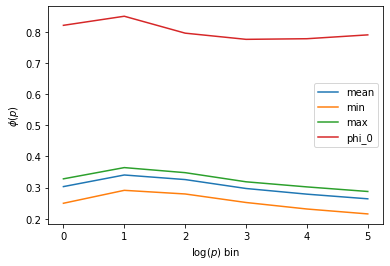

In [1305]:
quick_test = df_pew_trunc_p_bins.groupby('pop_bin').mean()
quick_test = quick_test.reset_index()
display(quick_test)



plt.plot(quick_test['phi_w_mean'],label='mean')
plt.plot(quick_test['phi_w_min'],label='min')
plt.plot(quick_test['phi_w_max'],label='max')
plt.plot(quick_test['Family Available'],label='phi_0')
plt.xlabel('$\log(p)$ bin')
plt.ylabel('$\phi(p)$')
plt.legend(loc='center right')
#plt.yscale('log')
#plt.ylim(0,12)

In [1386]:
n_bins = 6
df_cbsa
cbsa_pop_df = copy.deepcopy(df_cbsa)
cbsa_pop_df = cbsa_pop_df[cbsa_pop_df['GTCBSA'].isin(df_tus_trunc['GTCBSA'].tolist())]
cbsa_pop_df['pop_bin'] = pd.cut(cbsa_pop_df['LOG_POP'], n_bins,)
cbsa_pop_df

# cbsa_bins = copy.deepcopy(cbsa_pop_df[['GTCBSA','pop_bin']])
# df_pew_trunc_p_bins = copy.deepcopy(df_pew_trunc)
# df_pew_trunc_p_bins = cbsa_bins.merge(df_pew_trunc_p_bins, on='GTCBSA', how='right')
# df_pew_trunc_p_bins

c_phis_p = {}

c1, c2, pbin, phic, col1, col2 = [],[],[],[],[],[]

for s_col in ['SexClass']:
    for col in ['AgeClass','RaceEthn', 'EduClass']:
        combined = s_col + '_&_' + col
        tdf = copy.deepcopy(df_pew_trunc_p_bins)
        tdf = tdf[~tdf[col].isna()]
        tdf = tdf[~tdf[s_col].isna()]
        c_phis_p[combined] = {}
        for var_s in tdf[s_col].unique():
            for var in tdf[col].unique():
                combined_var = var_s + '_&_' + var
                c_phis_p[combined][combined_var] = {}
                for bin_group in tdf.pop_bin.unique():
                    ttdf = tdf[tdf['pop_bin']==bin_group]
                    ttdf = ttdf[ttdf[col]==var]
                    ttdf = ttdf[ttdf[s_col]==var_s]
                    t_phi = ttdf['phi_w_max'].mean()
                    c_phis_p[combined][combined_var][bin_group] = t_phi

                    c1.append(var)
                    c2.append(var_s) 
                    pbin.append(bin_group)
                    phic.append(t_phi)
                    col1.append(col)
                    col2.append(s_col)
c_phis_p['SexClass_&_AgeClass']

c_phis_p_df = pd.DataFrame({
                    'class1_type': col1,
                    'class2_type': col2,
                    'class1':c1,
                    'class2':c2,
                    'pop_bin': pbin,
                    'phi_c':phic
                })

display(c_phis_p_df.head(10))
c_phis_p_df.shape

class1_type class2_type      class1  class2         pop_bin     phi_c
0    AgeClass    SexClass  23<=Age<60  Female  (5.737, 6.125]  0.375758
1    AgeClass    SexClass  23<=Age<60  Female  (6.513, 6.902]  0.311653
2    AgeClass    SexClass  23<=Age<60  Female  (4.958, 5.348]  0.338235
3    AgeClass    SexClass  23<=Age<60  Female  (6.125, 6.513]  0.328829
4    AgeClass    SexClass  23<=Age<60  Female   (6.902, 7.29]  0.371795
5    AgeClass    SexClass  23<=Age<60  Female  (5.348, 5.737]  0.364943
6    AgeClass    SexClass     Age>=60  Female  (5.737, 6.125]  0.268707
7    AgeClass    SexClass     Age>=60  Female  (6.513, 6.902]  0.196721
8    AgeClass    SexClass     Age>=60  Female  (4.958, 5.348]  0.364583
9    AgeClass    SexClass     Age>=60  Female  (6.125, 6.513]  0.304688

(96, 6)

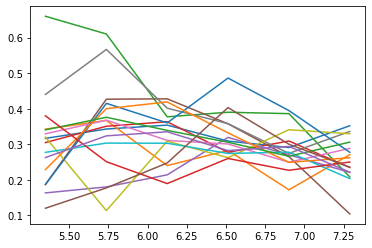

In [1331]:
c_phis_p_df['cc'] = c_phis_p_df['class1'] + '_'+c_phis_p_df['class2']

plt.figure()
for c in c_phis_p_df['cc'].unique():
    tdf = c_phis_p_df[c_phis_p_df['cc'] == c]
    tdf = tdf.sort_values('pop_bin')
    plt.plot([i.right for i in tdf['pop_bin'].tolist()], tdf['phi_c'])

# Start here

In [1399]:
# EQ 62 - # \undertilde\kappa(g,c,a)
# 

#phi_c_expected = c_phis_p # previously calculated

alphas, cbsas, c_var1, c_var2, kappas = [],[],[],[],[]
s_vals = []
alphas_dict = {}

for alpha, _ in v_alpha.items():
    #for col, val in c_phis.items():
    for idx, row in c_phis_p_df.iterrows():
        col1 = row['class1_type']
        col2 = row['class2_type']
        var1 = row['class1']
        var2 = row['class2']
        r_phi_c = row['phi_c']

        tdf = df_tus_trunc_bin[['TUCASEID','pop_bin', 'NEW_WEIGHT','GTCBSA', alpha, col1, col2, 'LONGEST_TRIP_DUR', 'TUDIARYDAY']]
        ttdf = tdf[tdf[col1]==var1].copy()
        ttdf = ttdf[ttdf[col2]==var2].copy()
        
        # TRAVEL CORRECTION LOGIC
        ttdf['within_ell'] = ttdf['LONGEST_TRIP_DUR'].apply(lambda x: 1 if x > 0 and x <=60 else 0)
        ttdf['incoming_trav'] = ttdf['LONGEST_TRIP_DUR'].apply(lambda x: v_score if  np.isnan(x) else 0)
        ttdf[alpha] = ttdf[alpha] * (ttdf['within_ell']+ttdf['incoming_trav'])
        # END TRAVEL CORRECTION LOGIC

        for cbsa in ttdf['GTCBSA'].unique():
            tttdf = ttdf[ttdf['GTCBSA']==cbsa].copy()
            tttdf = tttdf.reset_index()
            s = len(tttdf)
            s_vals.append(s)
            bin_ = tttdf['pop_bin'].loc[0]
            kappa_tilde_gca = sum(tttdf[alpha]) / (s*r_phi_c)
            cbsas.append(cbsa)
            alphas.append(alpha)
            #cs.append(col)
            c_var1.append(var1)
            c_var2.append(var2)
            kappas.append(kappa_tilde_gca)


kappa_tilde_gca_df = pd.DataFrame({'alpha':alphas, 
                                    #'c_type':cs,
                                    'GTCBSA':cbsas,
                                    'c1':c_var1,
                                    'c2':c_var2,
                                    'kappa_tilde(gca)':kappas})

kappa_tilde_gca_df = kappa_tilde_gca_df.pivot_table(values=['kappa_tilde(gca)'], index=['alpha','GTCBSA' ], columns=['c1', 'c2'])

In [1400]:
kappa_gca_v2 = kappa_tilde_gca_df.copy()
kappa_gca_v2 = kappa_gca_v2.reset_index()
cols = kappa_gca_v2.columns.to_flat_index().tolist()
cols = [i[2]+'_&_'+i[1] for i in cols]
cols[0] = 'alpha'
cols[1] = 'GTCBSA'
kappa_gca_v2.columns = cols

for cc in kappa_gca_v2.columns.tolist()[2:]:
    kappa_gca_v2[cc] = kappa_gca_v2[cc].apply(lambda x: 1 if x > 1 else x)

kappa_gca_v2

alpha  GTCBSA  Female_&_23<=Age<60  Male_&_23<=Age<60  \
0        10_agg_H   10420             0.000000           0.000000   
1        10_agg_H   10580             0.000000           0.000000   
2        10_agg_H   10740             0.000000           0.000000   
3        10_agg_H   10900             0.000000           0.000000   
4        10_agg_H   11100             0.000000           0.000000   
...           ...     ...                  ...                ...   
4515  SOCIAL_TU_H   49180             1.000000           0.220244   
4516  SOCIAL_TU_H   49340             0.540360           0.327396   
4517  SOCIAL_TU_H   49620             1.000000           0.342601   
4518  SOCIAL_TU_H   49660             0.994903           1.000000   
4519  SOCIAL_TU_H   49740             1.000000           0.000000   

      Female_&_Age<23  Male_&_Age<23  Female_&_Age>=60  Male_&_Age>=60  \
0            0.000000       0.000000          0.000000        0.000000   
1            0.000000       0.000000          0.000000        0.000000   
2            0.000000       0.000000          0.000000        0.000000   
3            0.000000       0.000000          0.000000        0.000000   
4                 NaN       0.000000          0.000000        0.000000   
...               ...            ...               ...             ...   
4515         1.000000       0.465011          1.000000        0.681225   
4516         0.000000       0.940575          0.509947        0.913672   
4517         0.121786       0.000000          1.000000        0.000000   
4518         0.000000       1.000000          0.710169        0.540298   
4519         0.000000       1.000000          0.801345        1.000000   

      Female_&_Black  Male_&_Black  Female_&_HS+  Male_&_HS+  \
0           0.000000      0.000000      0.000000    0.000000   
1           0.000000      0.000000      0.000000    0.000000   
2           0.000000      0.000000      0.000000    0.000000   
3           0.000000      0.000000      0.000000    0.000000   
4                NaN      0.000000      0.000000    0.000000   
...              ...           ...           ...         ...   
4515        0.539292      0.000000      0.973004    0.350509   
4516        0.000000      0.000000      0.503807    0.487520   
4517        1.000000      0.000000      1.000000    0.204463   
4518        1.000000      0.716071      0.852551    0.817537   
4519             NaN           NaN      0.932894    0.000000   

      Female_&_Hispanic  Male_&_Hispanic  Female_&_LT_HS  Male_&_LT_HS  \
0              0.000000         0.000000        0.000000      0.000000   
1              0.000000         0.000000        0.000000      0.000000   
2              0.000000         0.000000        0.000000      0.000000   
3              0.000000         0.000000        0.000000      0.000000   
4              0.000000         0.000000        0.000000           NaN   
...                 ...              ...             ...           ...   
4515           0.746980         1.000000        1.000000      0.818985   
4516           1.000000         1.000000        0.000000      0.656662   
4517           0.000000         0.000000        0.224685      0.000000   
4518                NaN         0.000000        0.000000      0.818985   
4519           0.979887         0.383978        0.969535      1.000000   

      Female_&_White&Other  Male_&_White&Other  
0                 0.000000            0.000000  
1                 0.000000            0.000000  
2                 0.000000            0.000000  
3                 0.000000            0.000000  
4                 0.000000            0.000000  
...                    ...                 ...  
4515              1.000000            0.411147  
4516              0.461927            0.537764  
4517              1.000000            0.189924  
4518              0.786525            0.888078  
4519              1.000000            1.000000  

[4520 rows x 18 columns]

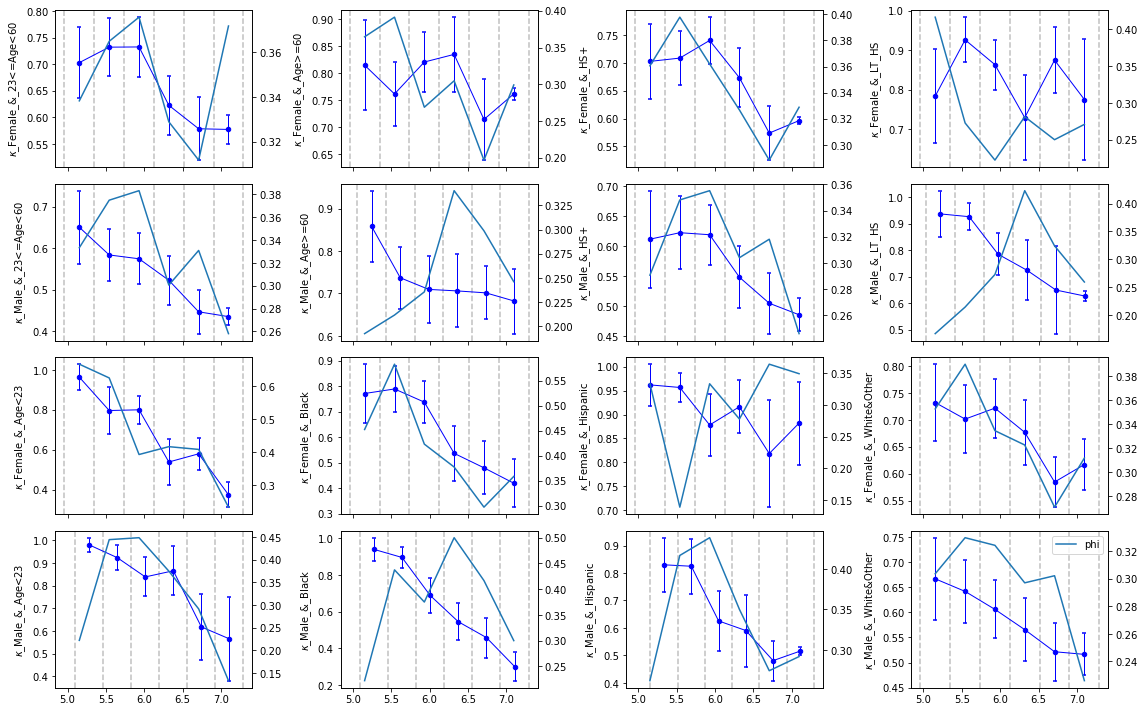

In [1401]:
kappa_temp = kappa_gca_v2.copy()
kappa_temp = kappa_temp[kappa_temp['alpha']=='ALL_TU_H']
kappa_temp = df_cbsa.merge(kappa_temp, how='right', on='GTCBSA')
col = kappa_temp.columns.tolist()[5:]

c_phis_p_df

fig, axes = plt.subplots(4,4, figsize=(16,10), sharex=True)
for idx, col in enumerate(col):
    tdf = kappa_temp[kappa_temp[col]>0]
    x = idx%4
    y = idx//4    
    axes[x,y] = binplot_dim(axes[x,y], tdf['LOG_POP'], tdf[col], 6, c='blue', l=1.5, label='', s=20)
    axes[x,y].set_ylabel(f'$\kappa$_'+col)
    classes = col.split('&')
    class1 = classes[0][:-1]
    class2 = classes[1][1:]
    if class2 == 'White':
        class2 = 'White&Other'

    tdf = c_phis_p_df[c_phis_p_df['class2'] == class1]
    tdf = tdf[tdf['class1']==class2]
    tdf = tdf.sort_values('pop_bin')

    ax2 = axes[x,y].twinx()
    ax2.plot([(i.right+i.left)/2 for i in tdf['pop_bin'].tolist()], tdf['phi_c'], label='phi')

plt.legend()
plt.tight_layout()


In [1402]:
alphas = kappa_gca_v2.alpha.unique().tolist()
cbsas = kappa_gca_v2.GTCBSA.unique().tolist()
characteristics = kappa_gca_v2.columns.tolist()[2:]
kga_dict = {'GTCBSA':cbsas}
for alpha in alphas:
    temp_list = []
    for cbsa in cbsas:
        p_row = p_df[p_df.GTCBSA==cbsa]
        k_row = kappa_gca_v2[kappa_gca_v2.GTCBSA==cbsa]
        k_row = k_row[k_row.alpha==alpha]
        c_p = [k_row[i].tolist()[0]*p_row[i].tolist()[0] for i in characteristics]
        c_p = sum([i for i in c_p if i > 0])
        p_tot = p_row.p.tolist()[0]
        kga = c_p / p_tot
        temp_list.append(kga)
    kga_dict[alpha] = temp_list

kga_2_df = pd.DataFrame(kga_dict)
kga_2_df = df_cbsa.merge(kga_2_df, how='right', on='GTCBSA')
kga_2_df

GTCBSA       POP  LOG_POP  NEW_WEIGHT  10_agg_H  11_agg_H  12_agg_H  \
0     10420  703845.0     5.85   2256628.0       0.0  0.287872  0.406547   
1     10580  880736.0     5.94   2830130.0       0.0  0.174871  0.487079   
2     10740  912108.0     5.96   2985120.0       0.0  0.220142  0.486682   
3     10900  837610.0     5.92   2633758.0       0.0  0.329643  0.378547   
4     11100  263776.0     5.42    723477.0       0.0  0.300983  0.406753   
..      ...       ...      ...         ...       ...       ...       ...   
221   49180  666216.0     5.82   2171339.0       0.0  0.444621  0.599371   
222   49340  941338.0     5.97   3108819.0       0.0  0.364672  0.372791   
223   49620  445565.0     5.65   1451810.0       0.0  0.390489  0.543079   
224   49660  541846.0     5.73   1815563.0       0.0  0.443667  0.714167   
225   49740  209468.0     5.32    594788.0       0.0  0.509136  0.694630   

     13_agg_H  14_agg_H  15_agg_H  ...   3_agg_H   4_agg_H   5_agg_H  \
0    0.032065  0.000000  0.000000  ...  0.067127  0.016682  0.000000   
1    0.068209  0.034640  0.033770  ...  0.000000  0.142326  0.026941   
2    0.021905  0.060435  0.019865  ...  0.019420  0.221193  0.018058   
3    0.034437  0.000000  0.000000  ...  0.034437  0.191637  0.000000   
4    0.000000  0.000000  0.000000  ...  0.116351  0.074660  0.074660   
..        ...       ...       ...  ...       ...       ...       ...   
221  0.108428  0.075053  0.038784  ...  0.070513  0.443874  0.000000   
222  0.030322  0.045625  0.000000  ...  0.024312  0.238239  0.000000   
223  0.052885  0.000000  0.000000  ...  0.052885  0.227833  0.000000   
224  0.000000  0.043438  0.043574  ...  0.116051  0.250910  0.000000   
225  0.072178  0.000000  0.000000  ...  0.000000  0.105985  0.000000   

      6_agg_H   7_agg_H   8_agg_H   9_agg_H  ALL_TU_H  CARE_TU_H  SOCIAL_TU_H  
0    0.000000  0.153358  0.035821  0.032065  0.566311   0.016682     0.479389  
1    0.000000  0.154969  0.000000  0.000000  0.650324   0.142326     0.509064  
2    0.018567  0.018567  0.000000  0.042488  0.650326   0.221193     0.508588  
3    0.000000  0.109351  0.036654  0.000000  0.597133   0.191637     0.449865  
4    0.000000  0.000000  0.000000  0.000000  0.639455   0.074660     0.406753  
..        ...       ...       ...       ...       ...        ...          ...  
221  0.000000  0.146824  0.000000  0.000000  0.855272   0.443874     0.739003  
222  0.000000  0.098991  0.000000  0.000000  0.591575   0.238239     0.502082  
223  0.000000  0.267830  0.000000  0.000000  0.768925   0.227833     0.638578  
224  0.000000  0.043574  0.000000  0.000000  0.866296   0.250910     0.801554  
225  0.086076  0.157374  0.000000  0.000000  0.874954   0.105985     0.790029  

[226 rows x 24 columns]

In [1403]:
kcols

['10_agg_H',
 '11_agg_H',
 '12_agg_H',
 '13_agg_H',
 '14_agg_H',
 '15_agg_H',
 '16_agg_H',
 '18_agg_H',
 '1_agg_H',
 '2_agg_H',
 '3_agg_H',
 '4_agg_H',
 '5_agg_H',
 '6_agg_H',
 '7_agg_H',
 '8_agg_H',
 '9_agg_H',
 'ALL_TU_H',
 'CARE_TU_H',
 'SOCIAL_TU_H']

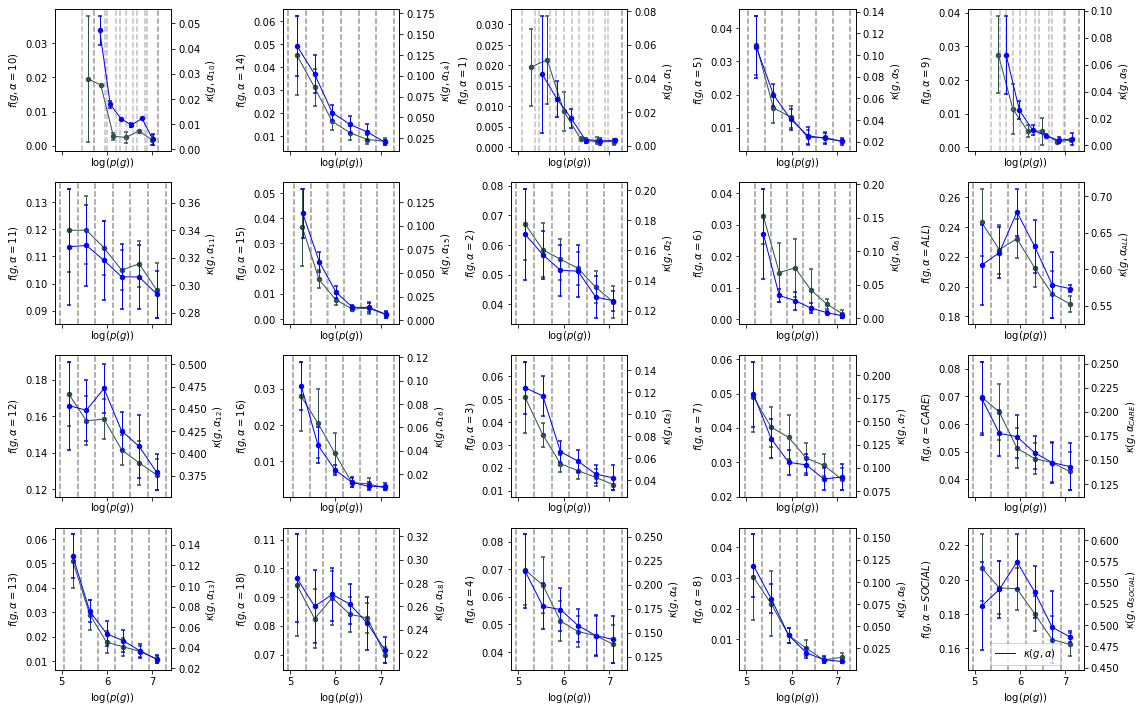

In [1404]:
cbsa_weights = df_cbsa[['GTCBSA', 'LOG_POP']]
f_df = cbsa_weights.merge(df_fg, on='GTCBSA', how='left')
fcols = sorted([i for i in f_df.columns.tolist() if 'all' in i])
flabels = [i.split('_')[2] for i in fcols]
kcols = ['10_agg_H',  '11_agg_H', '12_agg_H', '13_agg_H', '14_agg_H', '15_agg_H', 
    '16_agg_H', '18_agg_H', '1_agg_H', '2_agg_H', '3_agg_H', '4_agg_H', '5_agg_H', 
    '6_agg_H', '7_agg_H', '8_agg_H', '9_agg_H', 'ALL_TU_H', 'CARE_TU_H', 'SOCIAL_TU_H']



fig, axes = plt.subplots(4,5, figsize=(16,10), sharex=True)
for idx, col in enumerate(fcols):
    tdf = f_df[f_df[col]>0]
    x = idx%4
    y = idx//4
    axes[x,y] = binplot_dim(axes[x,y], tdf['LOG_POP'], tdf[col], 6, c='darkslategrey', l=1.5, label='$f(g,\\alpha)$', s=20)
    axes[x,y].set_ylabel(f'$f(g, \\alpha={flabels[idx]})$')
    axes[x,y].set_xlabel(f'$\log(p(g))$')


    tdf = kga_2_df[kga_2_df[kcols[idx]]>0]
    ax2 = axes[x,y].twinx()
    ax2 = binplot_dim(ax2, tdf['LOG_POP'], tdf[kcols[idx]], 6, c='blue', l=1.5, label='$\kappa(g,\\alpha)$', s=20)
    ax2.set_ylabel(f'$\kappa(g,{col_label[idx]})$')


plt.legend()
plt.tight_layout()
